In [ ]:
import csv
import datetime
import glob

import pickle
import scipy.sparse
import time
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter

sns.set_style('whitegrid')
sns.set_palette('pastel')
sns.set_context('notebook')

import warnings
warnings.filterwarnings('ignore')

**DEFINE TARGET IND LATER ON!**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/refit_redd_2nd_attempt.pk', 'rb') as f:
    data = pickle.load(f)

train, test = data['train'], data['test']

# **DSC & VSC (regular & transfer)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
print(torch.cuda.device_count())

1


In [ ]:
train = [train]
test = [test]

### Define models

In [ ]:
class DSC(nn.Module):
    def __init__(self, input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=False, DD_step=False):
        super(DSC, self).__init__()
        self.enable_transfer_learning = enable_transfer_learning
        self.DD_step = DD_step # for now
        self.encoder = nn.Sequential(
            nn.Conv1d(1, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.Conv1d(num_filters, num_filters, filter_size, padding=filter_size//2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(num_filters, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.ConvTranspose1d(num_filters, 1, filter_size, padding=filter_size//2),
            nn.LeakyReLU(),
        )
        #self.classifier = nn.Linear(encoding_dim, output_size)

        if self.DD_step:
            for param in self.encoder[:2].parameters():
                param.requires_grad = False

        if self.enable_transfer_learning:
            for param in self.encoder[:1].parameters():
                param.requires_grad = False

    def forward(self, x):
        z = self.encoder(x)
        a = torch.sign(z) * torch.relu(torch.abs(z) - 0.2)   # <--------- here is where the sparsity penalty occurs. The threshold is 0.01
        y_hat = self.decoder(a)
        #x_hat
        #y_hat = self.classifier(a.mean(dim=2))
        return y_hat, a, self.encoder[0].weight

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VSC(nn.Module):
    def __init__(self, input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=False, DD_step=False):#, beta):
        super(VSC, self).__init__()

        self.num_filters = num_filters
        self.encoding_dim = encoding_dim
        self.enable_transfer_learning = enable_transfer_learning
        self.DD_step = DD_step
        #self.beta = beta

        self.encoder = nn.Sequential(
            nn.Conv1d(1, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.Conv1d(num_filters, num_filters, filter_size, padding=filter_size//2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(num_filters, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.ConvTranspose1d(num_filters, 1, filter_size, padding=filter_size//2),
            nn.LeakyReLU(),
        )

        if self.DD_step:
            for param in self.encoder[:2].parameters():
                param.requires_grad = False

        if self.enable_transfer_learning:
            for param in self.encoder[:1].parameters():
                param.requires_grad = False

    def forward(self, x):
        z = self.encoder(x)
        mean = z.mean(dim=2)
        log_var = z.var(dim=2).log()

        # Sample from a spike and slab?*
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(z)  # not like std, more like z
        z = eps * std.unsqueeze(-1).repeat(1, 1, 317) + mean.unsqueeze(-1).repeat(1, 1, 317)

        # sparsify
        a = torch.sign(z) * F.relu(torch.abs(z) - 0.2)
        #a = a.unsqueeze(-1).repeat(1, 1, 171) # instead of repeat, smaple and create the 3rd dimension
        #print(a.shape, z.shape)
        y_hat = self.decoder(a)
        #kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        return y_hat, a, mean, log_var#, kl_loss


### Define training functions

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### DSC function

In [ ]:
def train_on_week_and_category(week, cat, learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False, target_ind=None, use_only_target_for_everything=False):
  # split data
  if enable_transfer_learning:
    X, X_t = train[week]['X_bar'].T.values[:8,:], train[week]['X_bar'].T.values[8:,:]
    y_cat, y_cat_t = train[week]['X'][cat].T.values[:8,:], train[week]['X'][cat].T.values[8:,:]
  elif use_only_target_for_everything:
    X = train[week]['X_bar'].T.values[8:,:]
    y_cat = train[week]['X'][cat].T.values[8:,:]
  else:
    X = train[week]['X_bar'].T.values
    y_cat = train[week]['X'][cat].T.values

  # 1) Deep Sparse Coding step, input and output are the same
  model = DSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=False)
  model.to(device)
  # Define loss and optimizer
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  print('----> Training for', cat)
  for epoch in range(num_epochs):
    running_loss = 0.0
    inputs, targets = torch.Tensor(y_cat).unsqueeze(1).to(device), torch.Tensor(y_cat).unsqueeze(1).to(device)
    optimizer.zero_grad()

    y_hat, a, encoder = model(inputs)
   #print('a_matrix is {} % sparse'.format(round(100*len(np.where(a.cpu() < 0.1)[0])/(13*25*170), 3)))
    #print('shapes',y_hat.shape, targets.shape)
    loss = criterion(y_hat, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # Print average loss for epoch (every n epochs)
    if epoch % display_every_n_epochs == 0:
      print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X)))

  weights = (model.encoder[0].weight, model.encoder[2].weight)

################################################################################################################################################

#2) transfer learning
  if enable_transfer_learning:
    # model ,loss and optimizer
    transfer_model = DSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=True)
    transfer_model.to(device)
    transfer_criterion = nn.MSELoss()
    transfer_optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

    print('----> Transfer training for {}'.format(cat))

    for epoch in range(num_epochs):
      running_loss = 0.0
      inputs, targets = torch.Tensor(y_cat_t).unsqueeze(1).to(device), torch.Tensor(y_cat_t).unsqueeze(1).to(device)
      transfer_optimizer.zero_grad()

      transfer_model.encoder[0].weight = weights[0]
      transfer_model.encoder[2].weight = weights[1]
      #transfer_model.encoder[4].weight = model.encoder[4].weight

      y_hat, a, encoder = transfer_model(inputs)
      # Compute loss and backpropagate
      loss = transfer_criterion(y_hat, targets)
      loss.backward()
      transfer_optimizer.step()

      running_loss += loss.item()

      # Print average loss for epoch (every n epochs)
      if epoch % display_every_n_epochs == 0:
        print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_t)))

    weights = (transfer_model.encoder[0].weight, transfer_model.encoder[2].weight)


################################################################################################################################################

#3) DD step, we freeze the encoder  and take the sparse code and dictionary of the Deep Sparse Coding step
  # model ,loss and optimizer
  dd_model = DSC(input_size, output_size, num_filters, filter_size, encoding_dim, DD_step=True)
  dd_model.to(device)
  dd_criterion = nn.MSELoss()
  dd_optimizer = optim.Adam(dd_model.parameters(), lr=0.001)

  print('----> DD step for {}'.format(cat))

  X_dd = X
  y_dd = y_cat
  if enable_transfer_learning:
    X_dd = X_t
    y_dd = y_cat_t

  for epoch in range(num_epochs):
    running_loss = 0.0
    inputs, targets = torch.Tensor(X_dd).unsqueeze(1).to(device), torch.Tensor(y_dd).unsqueeze(1).to(device)
    dd_optimizer.zero_grad()

    dd_model.encoder[0].weight = weights[0]
    dd_model.encoder[2].weight = weights[1]
    #dd_model.encoder[4].weight = model.encoder[4].weight

    y_hat, a, encoder = dd_model(inputs)
    #print('a_matrix is {} % sparse'.format(round(100*len(np.where(a.cpu() < 0.1)[0])/a.cpu().numel(), 3)))
    # Compute loss and backpropagate
    loss = dd_criterion(y_hat, targets)
    loss.backward()
    dd_optimizer.step()

    running_loss += loss.item()

    # Print average loss for epoch (every n epochs)
    if epoch % display_every_n_epochs == 0:
      print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_dd)))


  current_y_cat = y_hat.cpu().detach().numpy().T
  #if enable_transfer_learning:
  #  current_y_test_cat = transfer_model.forward(torch.Tensor(test[week]['X']['heating'].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T
  #else:
  current_y_test_cat = dd_model.forward(torch.Tensor(test[week]['X'][cat].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T

  return current_y_cat, current_y_test_cat

#### VSC function

In [ ]:
def VSC_train_on_week_and_category(week, cat, learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False, target_ind=None, use_only_target_for_everything=False):
  # split data
  if enable_transfer_learning:
    X, X_t = train[week]['X_bar'].T.values[:8,:], train[week]['X_bar'].T.values[8:,:]
    y_cat, y_cat_t = train[week]['X'][cat].T.values[:8,:], train[week]['X'][cat].T.values[8:,:]
  elif use_only_target_for_everything:
    X = train[week]['X_bar'].T.values[8:,:]
    y_cat = train[week]['X'][cat].T.values[8:,:]
  else:
    X = train[week]['X_bar'].T.values
    y_cat = train[week]['X'][cat].T.values


  # 1) Variational Sparse Coding step, input and output are the same
  model = VSC(input_size, output_size, num_filters, filter_size, encoding_dim)#, beta)
  model.to(device)
  # Define loss and optimizer
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  print('----> Training for', cat)
  for epoch in range(num_epochs):
    running_loss = 0.0
    inputs, targets = torch.Tensor(y_cat).unsqueeze(1).to(device), torch.Tensor(y_cat).unsqueeze(1).to(device)
    optimizer.zero_grad()

    y_hat, a, mean, logvar = model(inputs)
    #print('a_matrix is {} % sparse'.format(round(100*len(np.where(a.cpu() < 0.1)[0])/a.cpu().numel(), 3)))

    loss = criterion(y_hat, targets) # Reconstruction Loss, no KL divergence since this is a regression problem
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # Print average loss for epoch (every n epochs)
    if epoch % display_every_n_epochs == 0:
      print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X)))

  weights = (model.encoder[0].weight, model.encoder[2].weight)

################################################################################################################################################

#2) transfer learning
  if enable_transfer_learning:
    # model ,loss and optimizer
    transfer_model = VSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=True)
    transfer_model.to(device)
    transfer_criterion = nn.MSELoss()
    transfer_optimizer = optim.Adam(transfer_model.parameters(), lr=0.0005)

    print('----> Transfer training for {}'.format(cat))

    for epoch in range(num_epochs):
      running_loss = 0.0
      inputs, targets = torch.Tensor(y_cat_t).unsqueeze(1).to(device), torch.Tensor(y_cat_t).unsqueeze(1).to(device)
      transfer_optimizer.zero_grad()

      transfer_model.encoder[0].weight = weights[0]
      transfer_model.encoder[2].weight = weights[1]
      #transfer_model.encoder[4].weight = model.encoder[4].weight

      y_hat, a, mean, logvar = transfer_model(inputs)

      loss = criterion(y_hat, targets)  # Reconstruction Loss
      #loss = model.loss_function(y_hat, targets, mu, logvar, logspike, train=False)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      # Print average loss for epoch (every n epochs)
      if epoch % display_every_n_epochs == 0:
        print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_t)))

    weights = (transfer_model.encoder[0].weight, transfer_model.encoder[2].weight)


################################################################################################################################################

#3) DD step, we freeze the encoder and take the sparse code and dictionary of the Deep Sparse Coding step
  # model ,loss and optimizer
  dd_model = VSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=True, DD_step=True)
  dd_model.to(device)
  dd_criterion = nn.MSELoss()
  dd_optimizer = optim.Adam(dd_model.parameters(), lr=0.001)

  print('----> DD step for {}'.format(cat))

  X_dd = X
  y_dd = y_cat
  if enable_transfer_learning:
    X_dd = X_t
    y_dd = y_cat_t

  for epoch in range(num_epochs):
    running_loss = 0.0
    inputs, targets = torch.Tensor(X_dd).unsqueeze(1).to(device), torch.Tensor(y_dd).unsqueeze(1).to(device)
    dd_optimizer.zero_grad()

    dd_model.encoder[0].weight = weights[0]
    dd_model.encoder[2].weight = weights[1]
    #dd_model.encoder[4].weight = model.encoder[4].weight

    y_hat, a, mean, logvar = dd_model(inputs)
    # Compute loss and backpropagate
    loss = dd_criterion(y_hat, targets)
    loss.backward()
    dd_optimizer.step()

    running_loss += loss.item()

    # Print average loss for epoch (every n epochs)
    if epoch % display_every_n_epochs == 0:
      print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_dd)))

  current_y_cat = y_hat.cpu().detach().numpy().T
  if enable_transfer_learning:
    current_y_test_cat = transfer_model.forward(torch.Tensor(test[week]['X'][cat].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T
  else:
    current_y_test_cat = model.forward(torch.Tensor(test[week]['X'][cat].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T

  return current_y_cat, current_y_test_cat

### Hyperparameters and variables

In [ ]:
# Define hyperparameters
input_size = 315
output_size = 315
num_filters = 50
filter_size = 10
encoding_dim = 64
dsc_learning_rate = 0.0001
vsc_learning_rate = 0.0001

num_epochs = 201
num_epochs_vsc_transfer = 100
nb_displays = 4
display_every_n_epochs = num_epochs // nb_displays
target_ind = 8

appliance_categories = list(train[0]['X'].keys())
weeks_to_train = 1


In [ ]:
#weeks_to_train = 2

### **Training blocks**

#### DSC

In [ ]:
y_apps = []
y_apps_test = []
weeks_to_train = 1


t = time.time()
for week in range(weeks_to_train):
  print('WEEK {}'.format(week))
  current_y = dict()
  current_y_test = dict()
  for cat in appliance_categories:
    current_y_cat, current_y_test_cat = train_on_week_and_category(week, cat, dsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False)

    current_y[cat] = current_y_cat
    current_y_test[cat] = current_y_test_cat

  y_apps.append(current_y)
  y_apps_test.append(current_y_test)

print('training took {} seconds'.format(round(time.time() - t, 2)))

WEEK 0
----> Training for fridge
Epoch 0 loss: 356.220
Epoch 50 loss: 6.570
Epoch 100 loss: 3.676
Epoch 150 loss: 2.652
Epoch 200 loss: 2.018
----> DD step for fridge
Epoch 0 loss: 2772.128
Epoch 50 loss: 577.728
Epoch 100 loss: 359.808
Epoch 150 loss: 275.508
Epoch 200 loss: 249.878
----> Training for washing_drying
Epoch 0 loss: 2543.228
Epoch 50 loss: 32.482
Epoch 100 loss: 18.876
Epoch 150 loss: 13.777
Epoch 200 loss: 10.498
----> DD step for washing_drying
Epoch 0 loss: 2540.454
Epoch 50 loss: 2458.486
Epoch 100 loss: 1621.863
Epoch 150 loss: 1315.117
Epoch 200 loss: 1132.256
training took 15.41 seconds


#### Transfer DSC

In [ ]:
y_apps_tdsc = []
y_apps_test_tdsc = []
#weeks_to_train = 5 # len(train) - 1

for week in range(weeks_to_train):
  print('WEEK {}'.format(week))
  current_y = dict()
  current_y_test = dict()
  for cat in appliance_categories:
    current_y_cat, current_y_test_cat = train_on_week_and_category(week, cat, dsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=True, target_ind=target_ind)

    current_y[cat] = current_y_cat
    current_y_test[cat] = current_y_test_cat

  y_apps_tdsc.append(current_y)
  y_apps_test_tdsc.append(current_y_test)

WEEK 0
----> Training for fridge
Epoch 0 loss: 675.325
Epoch 50 loss: 13.088
Epoch 100 loss: 6.800
Epoch 150 loss: 4.305
Epoch 200 loss: 3.111
----> Transfer training for fridge
Epoch 0 loss: 617.445
Epoch 50 loss: 7.542
Epoch 100 loss: 4.648
Epoch 150 loss: 3.274
Epoch 200 loss: 2.421
----> DD step for fridge
Epoch 0 loss: 984.362
Epoch 50 loss: 540.177
Epoch 100 loss: 392.171
Epoch 150 loss: 341.553
Epoch 200 loss: 305.350
----> Training for washing_drying
Epoch 0 loss: 7501.510
Epoch 50 loss: 124.190
Epoch 100 loss: 77.811
Epoch 150 loss: 54.163
Epoch 200 loss: 38.108
----> Transfer training for washing_drying
Epoch 0 loss: 3985.710
Epoch 50 loss: 25.119
Epoch 100 loss: 21.497
Epoch 150 loss: 16.553
Epoch 200 loss: 14.081
----> DD step for washing_drying
Epoch 0 loss: 18429.631
Epoch 50 loss: 3485.654
Epoch 100 loss: 2868.309
Epoch 150 loss: 2332.214
Epoch 200 loss: 1970.816


#### VSC

In [ ]:
y_apps_vsc = []
y_apps_test_vsc = []
#weeks_to_train = 2 # len(train) - 1


t = time.time()
for week in range(weeks_to_train):
  print('WEEK {}'.format(week))
  current_y = dict()
  current_y_test = dict()
  for cat in appliance_categories:
    current_y_cat, current_y_test_cat = VSC_train_on_week_and_category(week, cat, vsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False)

    current_y[cat] = current_y_cat
    current_y_test[cat] = current_y_test_cat

  y_apps_vsc.append(current_y)
  y_apps_test_vsc.append(current_y_test)

print('training took {} seconds'.format(round(time.time() - t, 2)))

WEEK 0
----> Training for fridge
Epoch 0 loss: 489.468
Epoch 50 loss: 217.698
Epoch 100 loss: 211.493
Epoch 150 loss: 209.086
Epoch 200 loss: 208.661
----> DD step for fridge
Epoch 0 loss: 1114.537
Epoch 50 loss: 522.505
Epoch 100 loss: 453.075
Epoch 150 loss: 305.996
Epoch 200 loss: 291.804
----> Training for washing_drying
Epoch 0 loss: 2512.963
Epoch 50 loss: 2524.085
Epoch 100 loss: 2444.197
Epoch 150 loss: 2442.015
Epoch 200 loss: 2430.994
----> DD step for washing_drying
Epoch 0 loss: 2558.043
Epoch 50 loss: 2482.154
Epoch 100 loss: 2467.833
Epoch 150 loss: 2466.125
Epoch 200 loss: 2466.627
training took 2.91 seconds


#### Transfer VSC

In [ ]:
y_apps_tvsc = []
y_apps_test_tvsc = []
#weeks_to_train = 5 # len(train) - 1

for week in range(weeks_to_train):
  print('WEEK {}'.format(week))
  current_y = dict()
  current_y_test = dict()
  for cat in appliance_categories:
    current_y_cat, current_y_test_cat = VSC_train_on_week_and_category(week, cat, vsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=True, target_ind=target_ind)

    current_y[cat] = current_y_cat
    current_y_test[cat] = current_y_test_cat

  y_apps_tvsc.append(current_y)
  y_apps_test_tvsc.append(current_y_test)

WEEK 0
----> Training for fridge
Epoch 0 loss: 1079.938
Epoch 50 loss: 427.411
Epoch 100 loss: 415.648
Epoch 150 loss: 408.615
Epoch 200 loss: 412.434
----> Transfer training for fridge
Epoch 0 loss: 624.644
Epoch 50 loss: 906.347
Epoch 100 loss: 859.376
Epoch 150 loss: 907.862
Epoch 200 loss: 912.065
----> DD step for fridge
Epoch 0 loss: 182730.932
Epoch 50 loss: 10971.022
Epoch 100 loss: 4244.222
Epoch 150 loss: 2466.292
Epoch 200 loss: 1655.145
----> Training for washing_drying
Epoch 0 loss: 8265.511
Epoch 50 loss: 7725.604
Epoch 100 loss: 7610.416
Epoch 150 loss: 7516.244
Epoch 200 loss: 7436.143
----> Transfer training for washing_drying
Epoch 0 loss: 3367.691
Epoch 50 loss: 3405.636
Epoch 100 loss: 3411.909
Epoch 150 loss: 3410.140
Epoch 200 loss: 3404.366
----> DD step for washing_drying
Epoch 0 loss: 69185.045
Epoch 50 loss: 4486.006
Epoch 100 loss: 4101.051
Epoch 150 loss: 3854.214
Epoch 200 loss: 3678.652


# **Metrics**

In [ ]:
def dd_acc_cat(y_apps, data, target_only=False):
  s = 0
  acc_dict = dict()
  for cat_ind, cat in enumerate(appliance_categories):
    y_app = y_apps[cat][:,0,:]
    if target_only:
      y_real = data['X'][cat].iloc[:,target_ind:].values
    else:
      y_real = data['X'][cat].values
    s += np.sum(np.abs(y_real - y_app), axis=0)
    acc_dict[cat] = np.sum(np.abs(y_real - y_app), axis=0)

  if target_only:
    den = 2*data['X_bar'].iloc[:,target_ind:].sum(axis=0).values
  else:
    den = 2*data['X_bar'].sum(axis=0).values
  return np.round(1 - s/den, 3), np.round(np.mean(1 - s/den), 3), {cat: 1 - v/den for cat,v in acc_dict.items()}

def dd_acc_cat_non_zero(y_apps, data, target_only=False):
  s = 0
  total_acc = 0
  house_range = data['X_bar'].shape[1] if not target_only else data['X_bar'].shape[1] + target_ind
  for house in range(house_range):
      sum_diff = 0
      for cat_ind, cat in enumerate(appliance_categories):
          y_app = y_apps[cat][:,0,:][:, house]
          y_real = data['X'][cat].iloc[:, house].values

          non_zero_inds = np.nonzero(y_real)[0]
          sub_real = y_real[non_zero_inds]
          sub_pred = y_app[non_zero_inds]
          sum_diff += np.sum(np.abs(sub_real - np.ravel(sub_pred)))
          #s += np.sum(np.abs(y_real - y_app), axis=0)
          #acc_dict[cat] = 1 - (np.sum(np.abs(y_real - y_app), axis=0))/(2*y_real.sum(axis=0))

      den = 2*data['X_bar'].iloc[:, house].values.sum()
      total_acc += 1 - sum_diff/den

  return np.round(total_acc / 5, 3)

def dd_acc_cat_thresholded(y_apps, data, threshold_percentage=0.05, target_only=False):
  s = 0
  total_acc = 0
  house_range = data['X_bar'].shape[1] if not target_only else data['X_bar'].shape[1] + target_ind
  for house in range(house_range):
      sum_diff = 0
      for cat_ind, cat in enumerate(appliance_categories):
          y_app = y_apps[cat][:,0,:][:, house]
          y_real = data['X'][cat].iloc[:, house].values

          threshold = y_real.max() * threshold_percentage
          non_zero_inds = np.where(y_real > threshold)[0]

          #non_zero_inds = np.nonzero(y_real)[0]
          sub_real = y_real[non_zero_inds]
          sub_pred = y_app[non_zero_inds]
          sum_diff += np.sum(np.abs(sub_real - np.ravel(sub_pred)))
          #s += np.sum(np.abs(y_real - y_app), axis=0)
          #acc_dict[cat] = 1 - (np.sum(np.abs(y_real - y_app), axis=0))/(2*y_real.sum(axis=0))

      den = 2*data['X_bar'].iloc[:, house].values.sum()
      total_acc += 1 - sum_diff/den

  return np.round(total_acc / 5, 3)

In [ ]:
dd_acc_cat_thresholded(y_apps_test[week], test[week])


0.442

In [ ]:
y_apps_test

[{'fridge': array([[[ 3.75674486e-01,  6.90625048e+00,  7.16270542e+00]],
  
         [[-6.83251303e-03,  9.27136803e+00,  9.00273609e+00]],
  
         [[-2.13949084e-02, -3.84943113e-02, -1.19385190e-01]],
  
         [[-4.09429446e-02, -1.92053661e-01, -1.55317813e-01]],
  
         [[ 4.24482155e+00,  3.93486166e+00, -4.87379730e-02]],
  
         [[-1.72633287e-02,  5.06097674e-01,  3.47630548e+00]],
  
         [[ 1.79131794e+00,  7.22055054e+00, -8.46263487e-03]],
  
         [[ 1.93171167e+00,  4.53638172e+00, -2.20215600e-03]],
  
         [[-3.29110608e-03,  1.29946241e+01, -5.72621152e-02]],
  
         [[-2.02865284e-02,  1.80494642e+00,  9.64647579e+00]],
  
         [[ 7.96669483e-01,  5.73654795e+00,  1.22783232e+00]],
  
         [[ 7.37374783e+00,  1.94771385e+00,  9.29439604e-01]],
  
         [[-4.42255475e-02,  2.03038330e+01, -2.19703224e-02]],
  
         [[ 5.08517313e+00,  9.41327763e+00,  4.64815521e+00]],
  
         [[-7.35214576e-02,  8.59106445e+00,  7.2993

In [ ]:
sns.set_context('poster')

average DD accuracy on weeks for Mix DSC 0.717
average DD accuracy on weeks for Transfer DSC 0.725
average DD accuracy on weeks for Mix VSC 0.582
average DD accuracy on weeks for Transfer VSC 0.694


<Figure size 1500x1600 with 0 Axes>

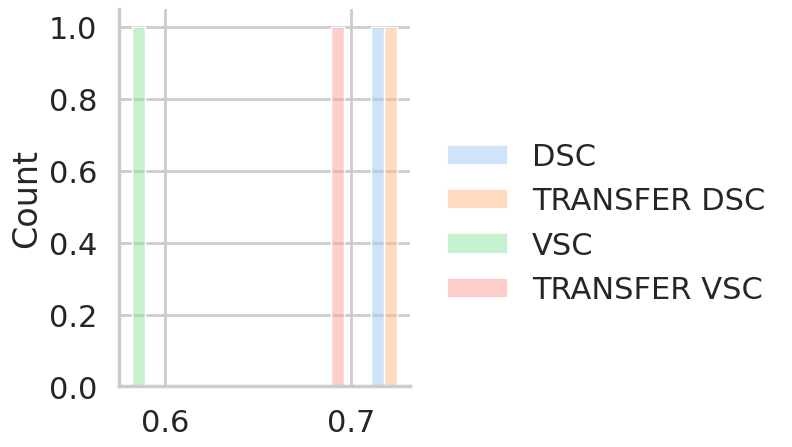

In [ ]:
def overall_accs_report(weeks_to_train):
  mix_res_list = []
  transfer_res_list = []
  for week in range(weeks_to_train - 1):
    mix_res_list.append(dd_acc_cat(y_apps_test[week], test[week])[1])
    transfer_res_list.append(dd_acc_cat(y_apps_test_tdsc[week], test[week])[1])


  vsc_res_list = []
  tvsc_res_list = []
  for week in range(weeks_to_train - 1):
    #if week != 7: #nan for some reason
    vsc_res_list.append(dd_acc_cat(y_apps_test_vsc[week], test[week])[1])
    tvsc_res_list.append(dd_acc_cat(y_apps_test_tvsc[week], test[week])[1])

  average_df = pd.DataFrame(
      {'DSC': mix_res_list,
      'TRANSFER DSC': transfer_res_list,
      'VSC': vsc_res_list,# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
      'TRANSFER VSC': tvsc_res_list,# + [np.mean(tvsc_res_list)],
      }
      )
  plt.figure(figsize=(15,16))
  sns.displot(average_df, kde=True, bins=20)
  #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks')
  plt.savefig(fname='Distribution of Accuracies.png')

  return round(np.mean(mix_res_list), 3), round(np.mean(transfer_res_list), 3), round(np.mean(vsc_res_list), 3), round(np.mean(tvsc_res_list), 3)


dsc, tdsc, vsc, tvsc = overall_accs_report(weeks_to_train + 1)


print('average DD accuracy on weeks for Mix DSC', dsc)
print('average DD accuracy on weeks for Transfer DSC', tdsc)
print('average DD accuracy on weeks for Mix VSC', vsc)
print('average DD accuracy on weeks for Transfer VSC', tvsc)


def per_cat_accs_report(weeks_to_train):
  mix_res_list = []
  transfer_res_list = []
  for week in range(weeks_to_train - 1):
    mix_res_list.append(dd_acc_cat(y_apps_test[week], test[week])[2])
    transfer_res_list.append(dd_acc_cat(y_apps_test_tdsc[week], test[week])[2])


  vsc_res_list = []
  tvsc_res_list = []
  for week in range(weeks_to_train - 1):
    #if week != 7: #nan for some reason
    vsc_res_list.append(dd_acc_cat(y_apps_test_vsc[week], test[week])[2])
    tvsc_res_list.append(dd_acc_cat(y_apps_test_tvsc[week], test[week])[2])

  for cat_ind, cat in enumerate(appliance_categories):
    average_df = pd.DataFrame(
        {'DSC': [item[cat] for item in mix_res_list],
        'TRANSFER DSC': [item[cat] for item in transfer_res_list],
        'VSC': [item[cat] for item in vsc_res_list],# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
        'TRANSFER VSC': [item[cat] for item in tvsc_res_list],# + [np.mean(tvsc_res_list)],
        }
        )
    plt.figure(figsize=(15,16))
    sns.displot(average_df, kde=True, bins=20)
    #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks for {}'.format(cat))
    plt.savefig(fname='Distribution of Accuracies for {}.png'.format(cat))

  return round(np.mean([item[cat] for item in mix_res_list]), 3), round(np.mean([item[cat] for item in transfer_res_list]), 3), round(np.mean([item[cat] for item in vsc_res_list]), 3), round(np.mean([item[cat] for item in tvsc_res_list]), 3)






average DD accuracy on weeks for Mix DSC 0.438
average DD accuracy on weeks for Transfer DSC 0.442
average DD accuracy on weeks for Mix VSC 0.425
average DD accuracy on weeks for Transfer VSC 0.427


<Figure size 1500x1600 with 0 Axes>

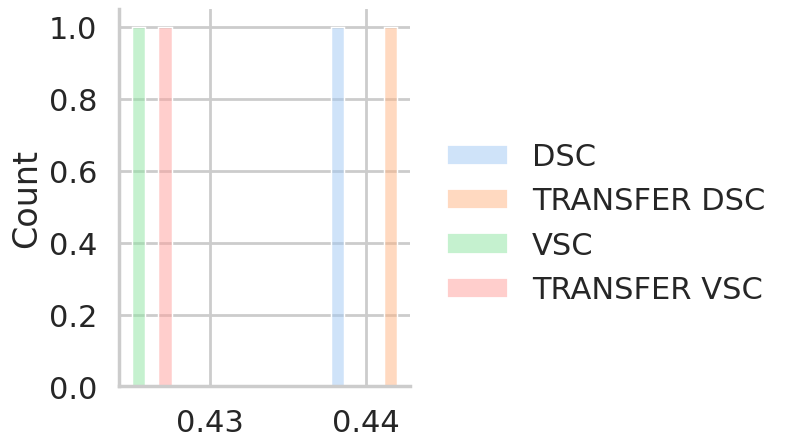

In [ ]:
def overall_non_zero_accs_report(weeks_to_train):
  mix_res_list = []
  transfer_res_list = []
  for week in range(weeks_to_train - 1):
    mix_res_list.append(dd_acc_cat_non_zero(y_apps_test[week], test[week]))
    transfer_res_list.append(dd_acc_cat_non_zero(y_apps_test_tdsc[week], test[week]))


  vsc_res_list = []
  tvsc_res_list = []
  for week in range(weeks_to_train - 1):
    #if week != 7: #nan for some reason
    vsc_res_list.append(dd_acc_cat_non_zero(y_apps_test_vsc[week], test[week]))
    tvsc_res_list.append(dd_acc_cat_non_zero(y_apps_test_tvsc[week], test[week]))

  average_df = pd.DataFrame(
      {'DSC': mix_res_list,
      'TRANSFER DSC': transfer_res_list,
      'VSC': vsc_res_list,# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
      'TRANSFER VSC': tvsc_res_list,# + [np.mean(tvsc_res_list)],
      }
      )
  plt.figure(figsize=(15,16))
  sns.displot(average_df, kde=True, bins=20)
  #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks')
  plt.savefig(fname='Distribution of Accuracies.png')

  return round(np.mean(mix_res_list), 3), round(np.mean(transfer_res_list), 3), round(np.mean(vsc_res_list), 3), round(np.mean(tvsc_res_list), 3)

dsc, tdsc, vsc, tvsc = overall_non_zero_accs_report(weeks_to_train + 1)


print('average DD accuracy on weeks for Mix DSC', dsc)
print('average DD accuracy on weeks for Transfer DSC', tdsc)
print('average DD accuracy on weeks for Mix VSC', vsc)
print('average DD accuracy on weeks for Transfer VSC', tvsc)



In [ ]:
from sklearn.metrics import mean_squared_error

def dd_acc_cat(y_apps, data, target_only=False):
  s = 0
  acc_dict = dict()
  for cat_ind, cat in enumerate(appliance_categories):
    y_app = y_apps[cat][:,0,:]
    if target_only:
      y_real = data['X'][cat].iloc[:,target_ind:].values
    else:
      y_real = data['X'][cat].values
    s += np.sum(np.abs(y_real - y_app), axis=0)
    acc_dict[cat] = np.sum(np.abs(y_real - y_app), axis=0)

  if target_only:
    den = 2*data['X_bar'].iloc[:,target_ind:].sum(axis=0).values
  else:
    den = 2*data['X_bar'].sum(axis=0).values
  return np.round(1 - s/den, 3), np.round(np.mean(1 - s/den), 3), {cat: 1 - v/den for cat,v in acc_dict.items()}


week = 0
def dd_acc_per_category(y_apps, data, target_only=False):
    s = 0
    error_dict = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        y_app = y_apps[cat][:,0,:]
        if target_only:
            y_real = data['X'][cat].iloc[:,target_ind:].values
        else:
            y_real = data['X'][cat].values
        s += np.sum(np.abs(y_real - y_app), axis=0)
        error_dict[cat] = np.sqrt(mean_squared_error(y_real, y_app)), np.sqrt(mean_squared_error(y_real, y_app))/np.linalg.norm(y_real, 2)

    return error_dict

In [ ]:
def per_cat_accs_report(weeks_to_train):
  mix_res_list = []
  transfer_res_list = []
  for week in range(weeks_to_train - 1):
    mix_res_list.append(dd_acc_per_category(y_apps_test[week], test[week]))
    transfer_res_list.append(dd_acc_per_category(y_apps_test_tdsc[week], test[week]))


  vsc_res_list = []
  tvsc_res_list = []
  for week in range(weeks_to_train - 1):
    #if week != 7: #nan for some reason
    vsc_res_list.append(dd_acc_per_category(y_apps_test_vsc[week], test[week]))
    tvsc_res_list.append(dd_acc_per_category(y_apps_test_tvsc[week], test[week]))

  for cat_ind, cat in enumerate(appliance_categories):
    average_df = pd.DataFrame(
        {'DSC': [item[cat] for item in mix_res_list],
        'TRANSFER DSC': [item[cat] for item in transfer_res_list],
        'VSC': [item[cat] for item in vsc_res_list],# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
        'TRANSFER VSC': [item[cat] for item in tvsc_res_list],# + [np.mean(tvsc_res_list)],
        }
        )

  for cat in appliance_categories:
      errors_mix = [d[cat][0] for d in mix_res_list]
      print('average DSC error for {} is {}'.format(cat, np.round(np.mean(errors_mix))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in mix_res_list]), 3)))
      errors_source = [d[cat][0] for d in transfer_res_list]
      print('average T-DSC error for {} is {}'.format(cat, np.round(np.mean(errors_source))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in transfer_res_list]), 3)))
      errors_target = [d[cat][0] for d in vsc_res_list]
      print('average VSC error for {} is {}'.format(cat, np.round(np.mean(errors_target))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in vsc_res_list]), 3)))
      errors_tsc = [d[cat][0] for d in tvsc_res_list]
      print('average T-VSC error for {} is {}'.format(cat, np.round(np.mean(errors_tsc))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in tvsc_res_list]), 3)))
      print("\n")


  return errors_mix, errors_source, errors_target, errors_tsc


sc_cat, ssc_cat, tarsc_cat, tsc_cat = per_cat_accs_report(weeks_to_train)


#print('average DD sqrt error per category on weeks for Mix SC', sc_cat)
#print('average DD sqrt error per category on weeks for Source only SC, target only DD', ssc_cat)
#print('average DD sqrt error per category on weeks for Target only SC and DD', tarsc_cat)
#print('average DD sqrt error per category on weeks for Transfer SC', tsc_cat)


average DSC error for fridge is nan ratio is nan
average T-DSC error for fridge is nan ratio is nan
average VSC error for fridge is nan ratio is nan
average T-VSC error for fridge is nan ratio is nan


average DSC error for washing_drying is nan ratio is nan
average T-DSC error for washing_drying is nan ratio is nan
average VSC error for washing_drying is nan ratio is nan
average T-VSC error for washing_drying is nan ratio is nan




# **PLOTS**

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
method_dict = {
    'DSC': y_apps_test,
    'Transfer DSC': y_apps_test_tdsc,
    'VSC': y_apps_test_vsc,
    'Transfer VSC': y_apps_test_tvsc,
}
colors = ['red', 'green', 'orange', 'purple']
data_source = ''

nb_houses = test[0]['X_bar'].shape[1]
nb_houses

3

In [ ]:
def get_all_category_plots_by_method(data, nb_houses, nb_weeks, data_type='test'):
    for ind, cat in enumerate(appliance_categories):
        figs, axes = [], []
        for week in range(nb_weeks):
            for house in range(nb_houses):

                fig, ax = plt.subplots(figsize=(20, 20), nrows=len(list(method_dict.keys())))
                xt = test[week]['X'][appliance_categories[ind]]
                house_name = xt.columns[house]
                plt.suptitle('Week {}, house {}'.format(week, house_name), fontsize=20)

                for method_ind, (method, y_apps) in enumerate(method_dict.items()):
                    xt_pred = y_apps[week][appliance_categories[ind]][:,:,house]

                    ax[method_ind].plot([i*100 for i in range(len(xt))], xt.values[:,house], c='blue', alpha=0.5)
                    ax[method_ind].plot([i*100 for i in range(len(xt_pred))], xt_pred, c=colors[method_ind], alpha=0.5)
                    ax[method_ind].set_xlabel('Timestamp', fontsize=24)
                    ax[method_ind].set_ylabel('Consumption', fontsize=24)
                    ax[method_ind].set_title('DD for {} house {}, method={}, category={}'.format(data_type, house_name, method, cat), fontsize=26)
                    ax[method_ind].legend(['real', 'predicted'])
                plt.tight_layout()
                figs.append(fig)
                axes.append(ax)

        with PdfPages('all_{}_plots_by_method_{}_{}.pdf'.format(cat, data_type, data_source), 'w') as pdf:
            for fig in figs:
                pdf.savefig(fig)

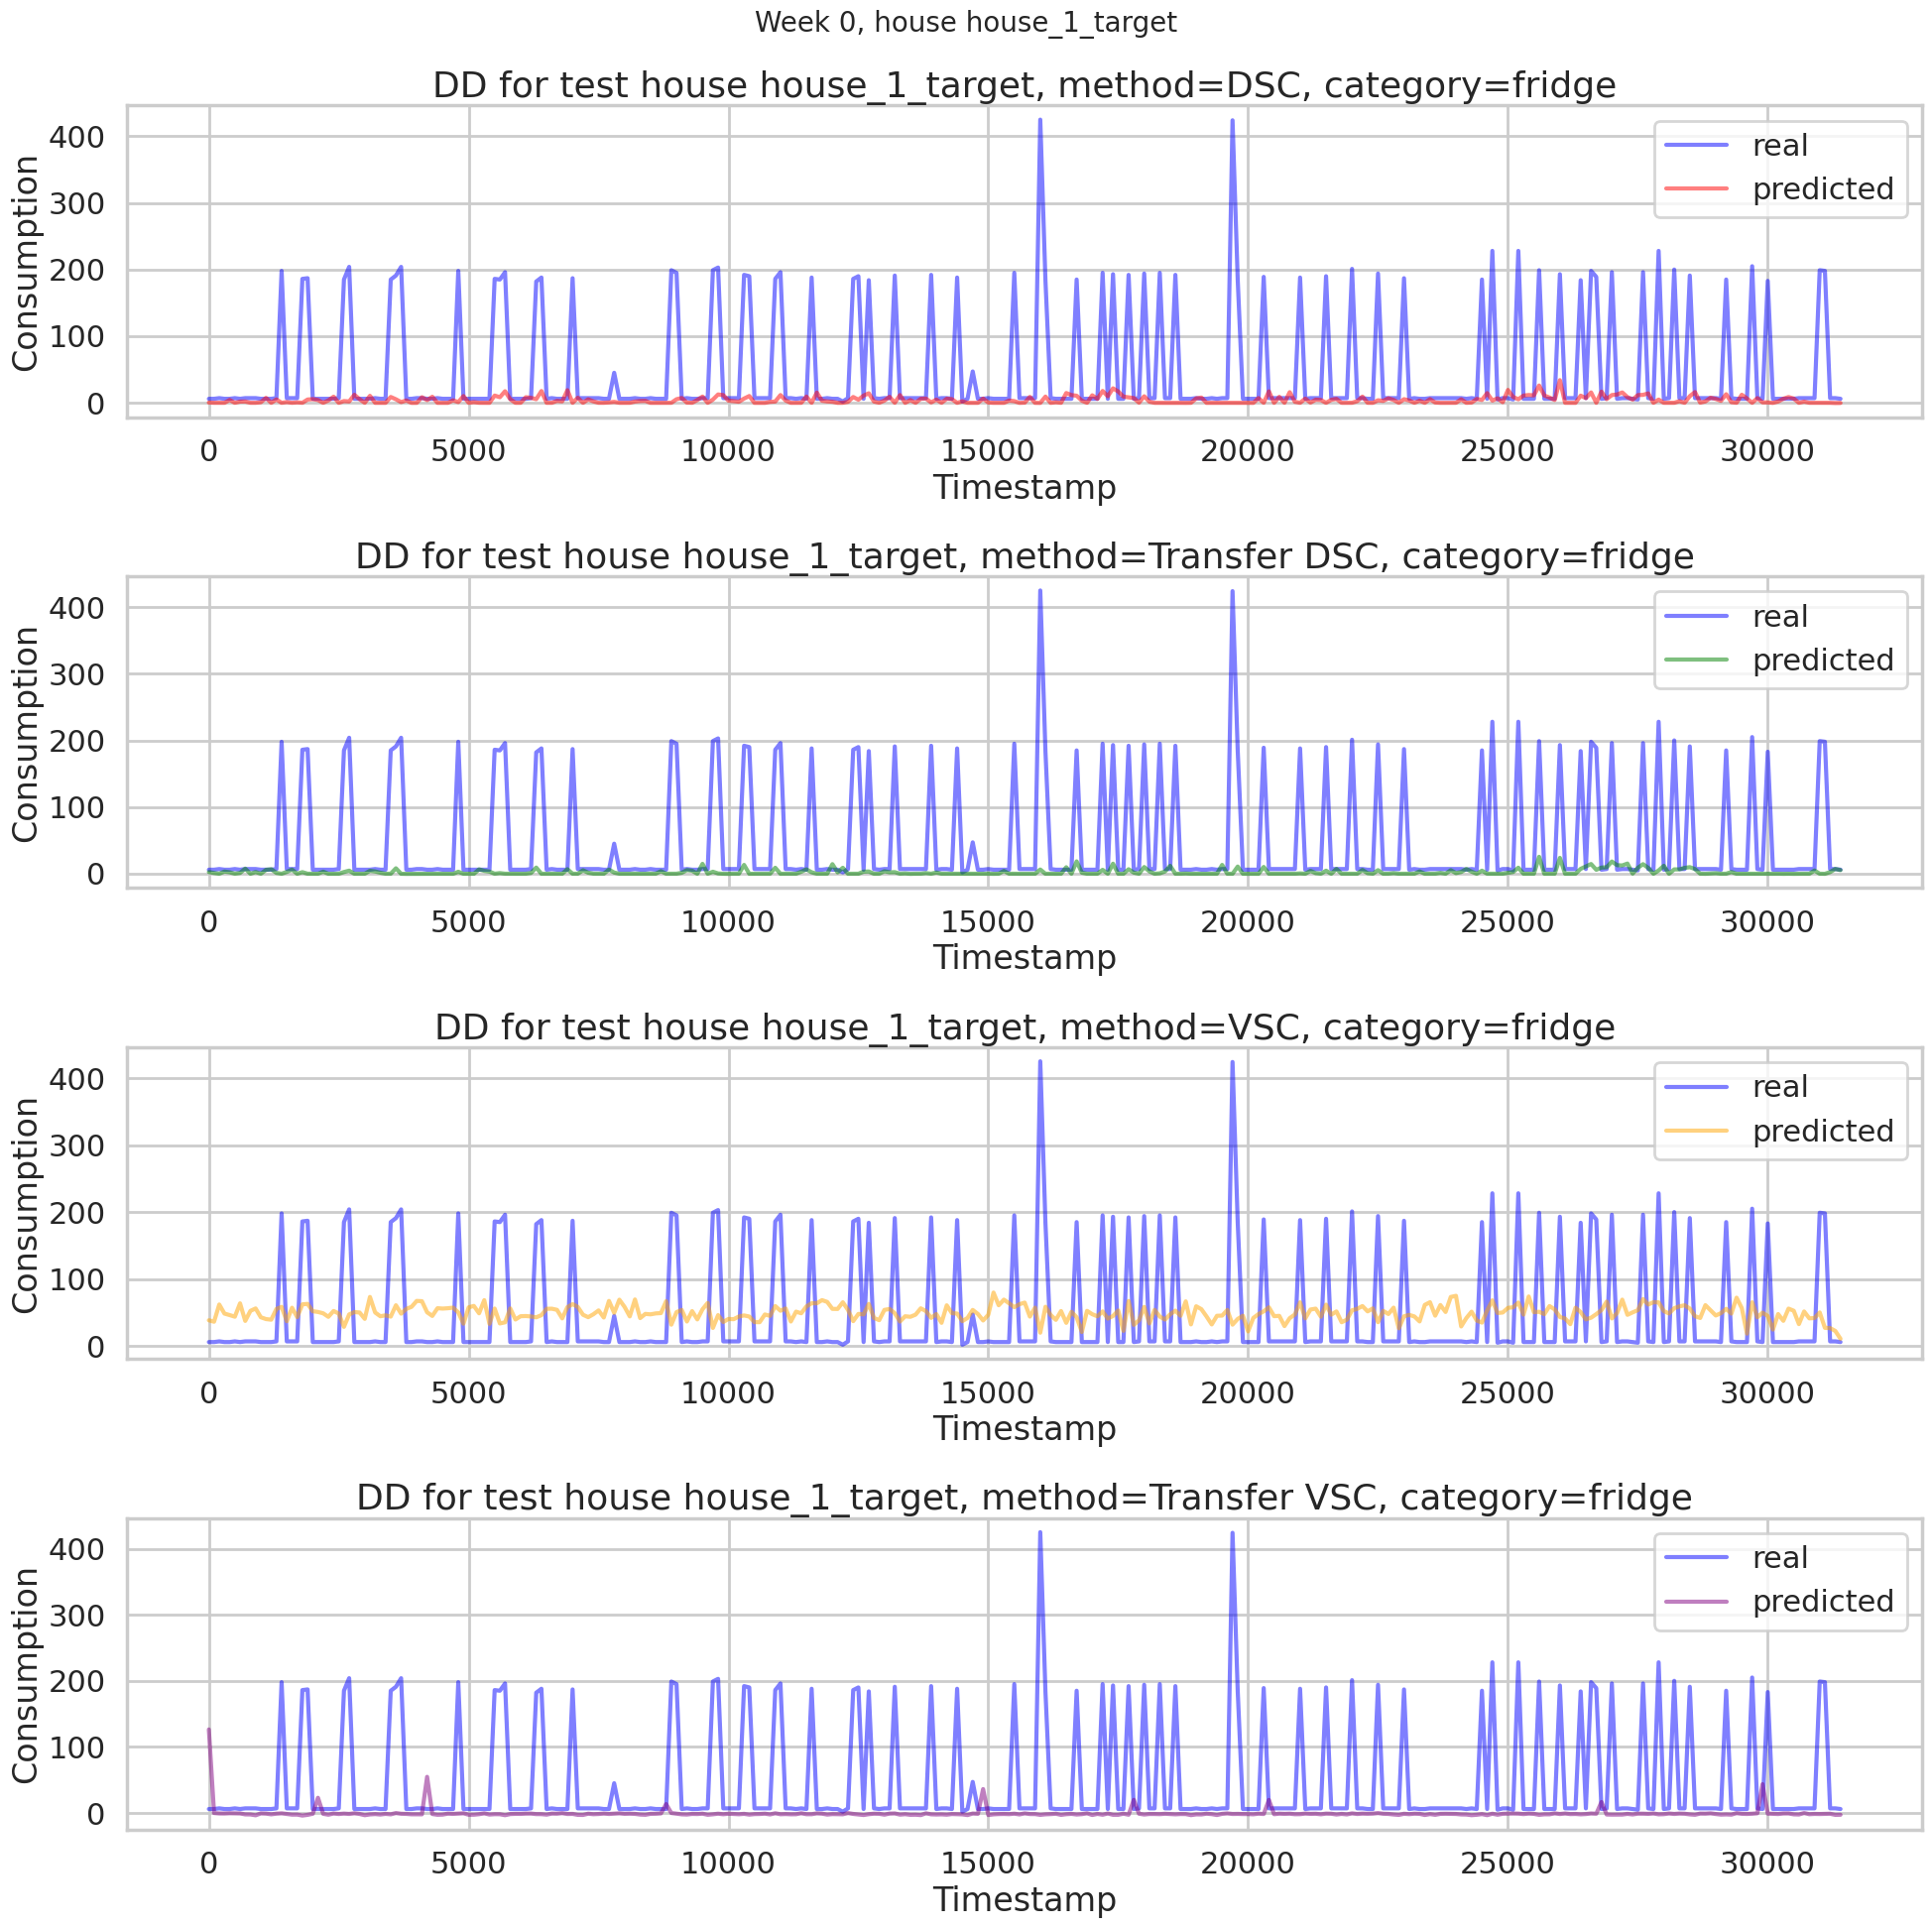

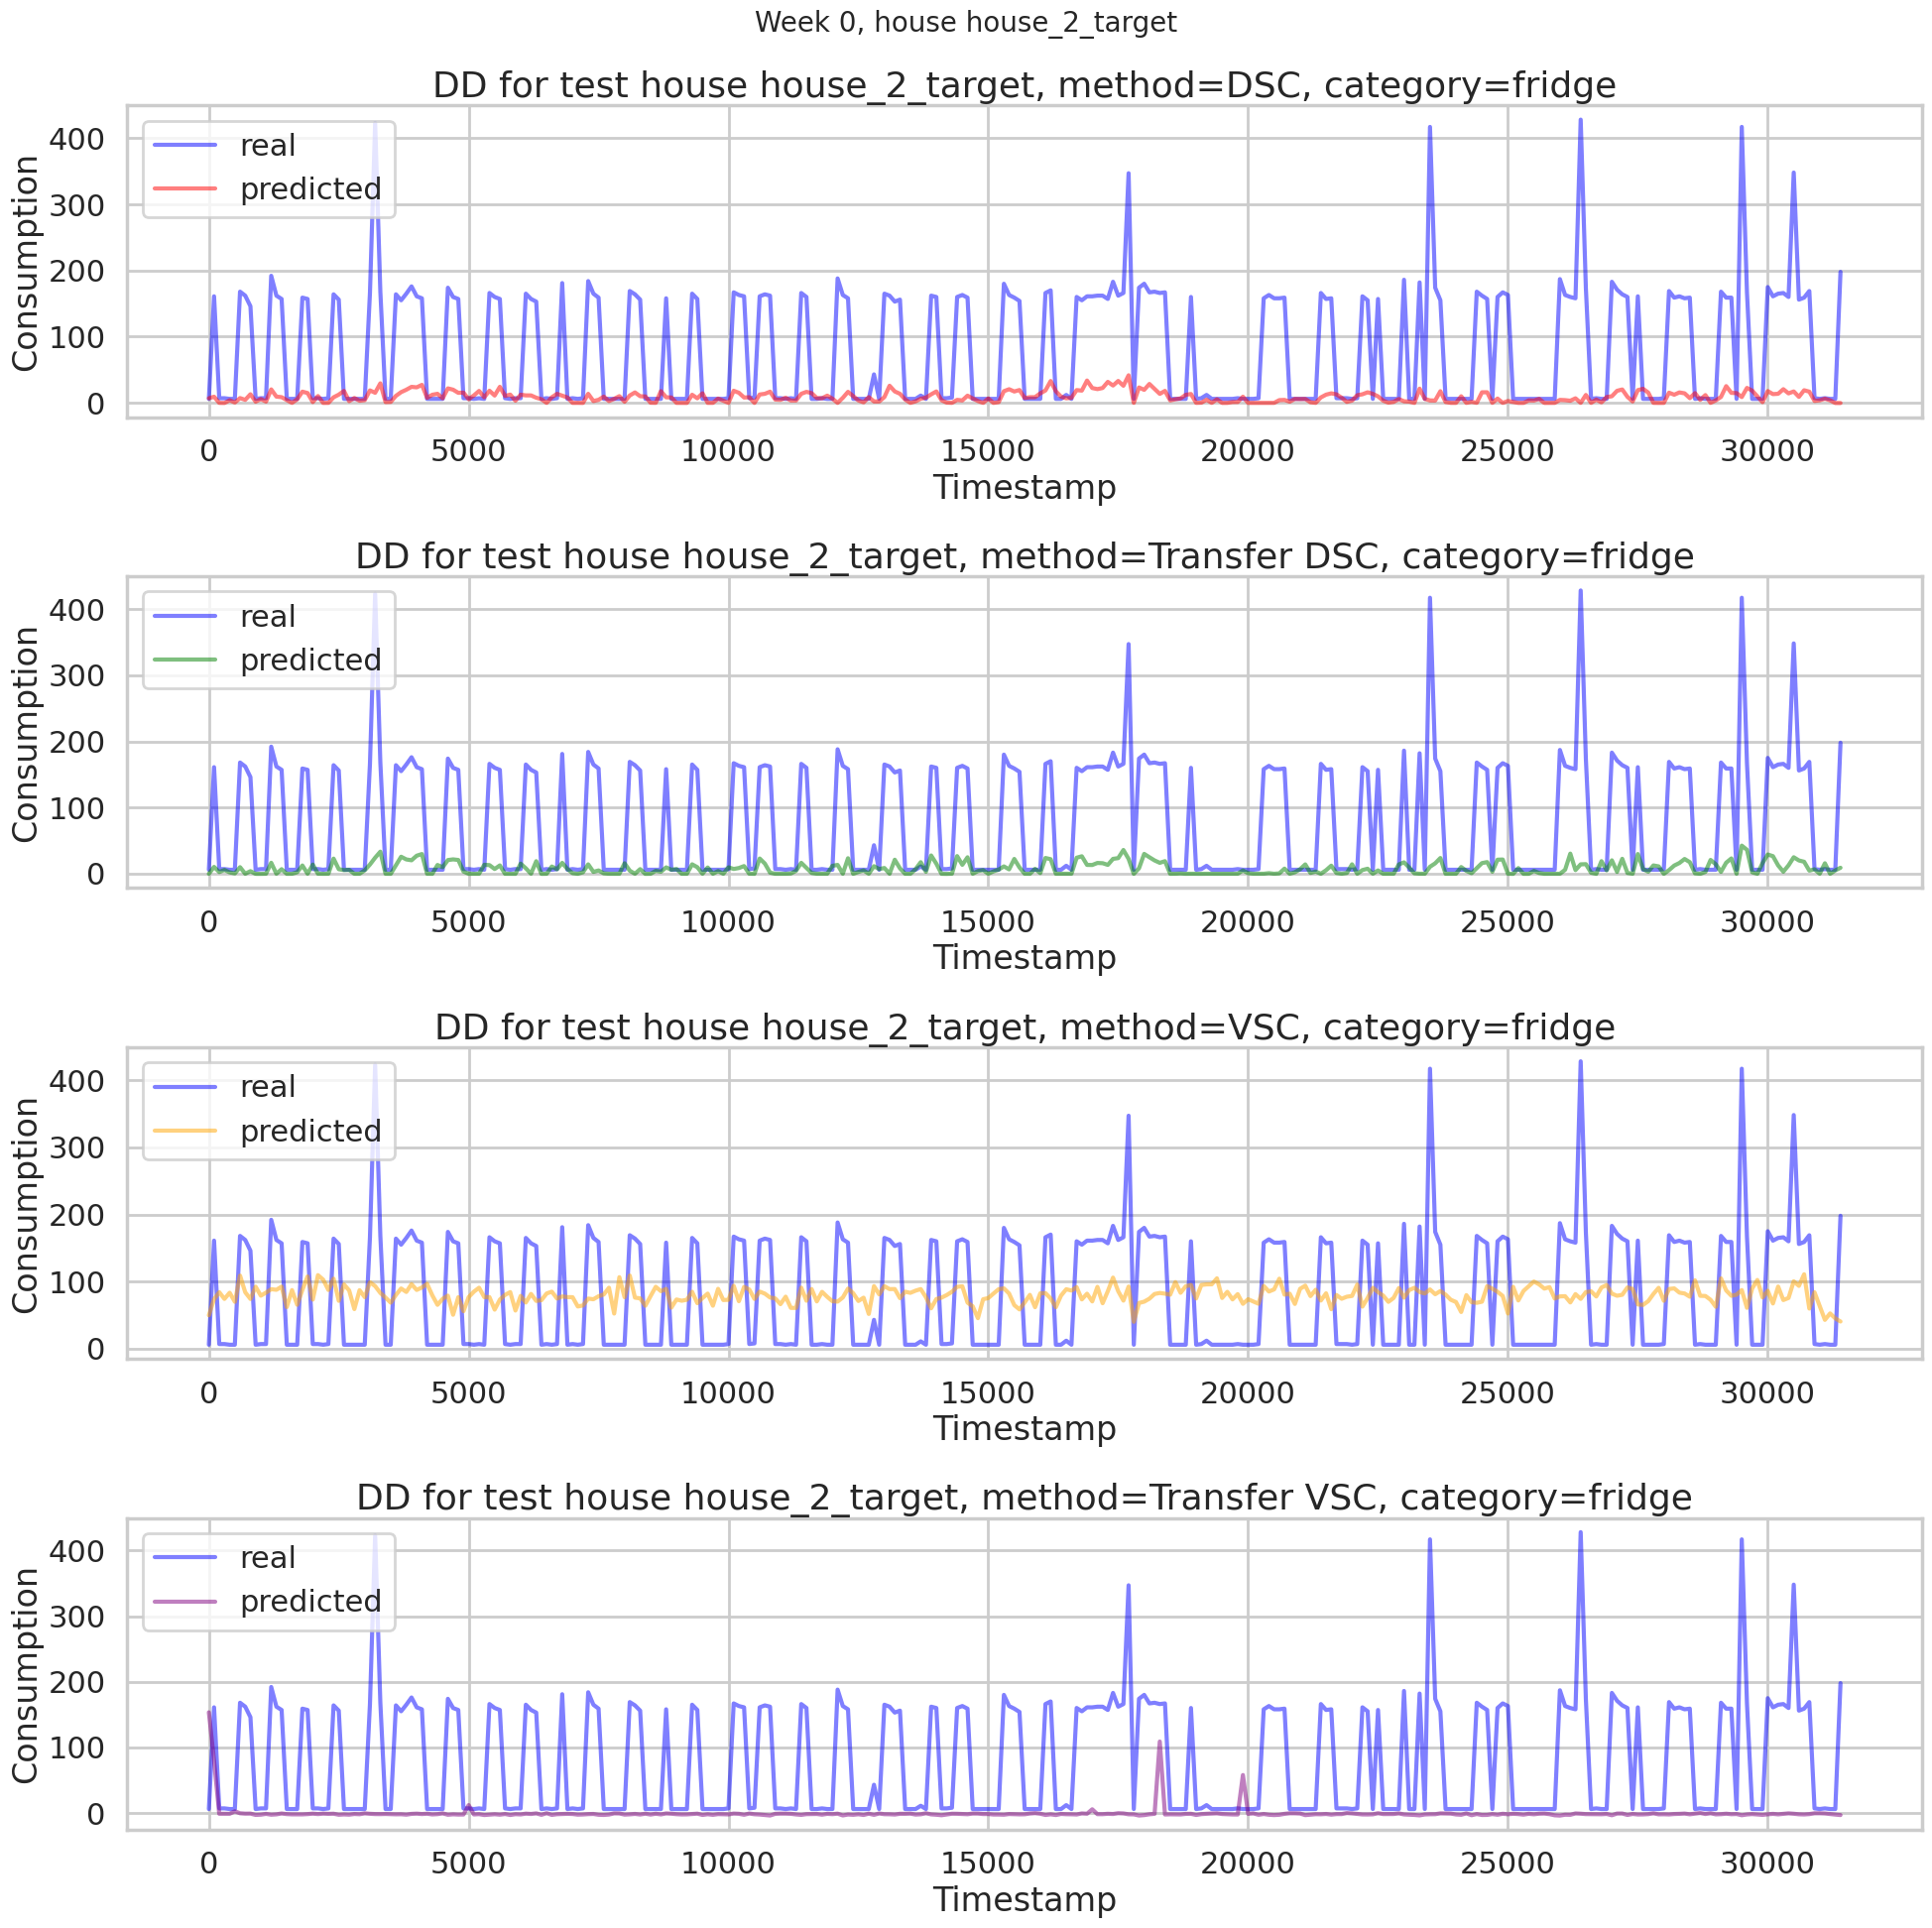

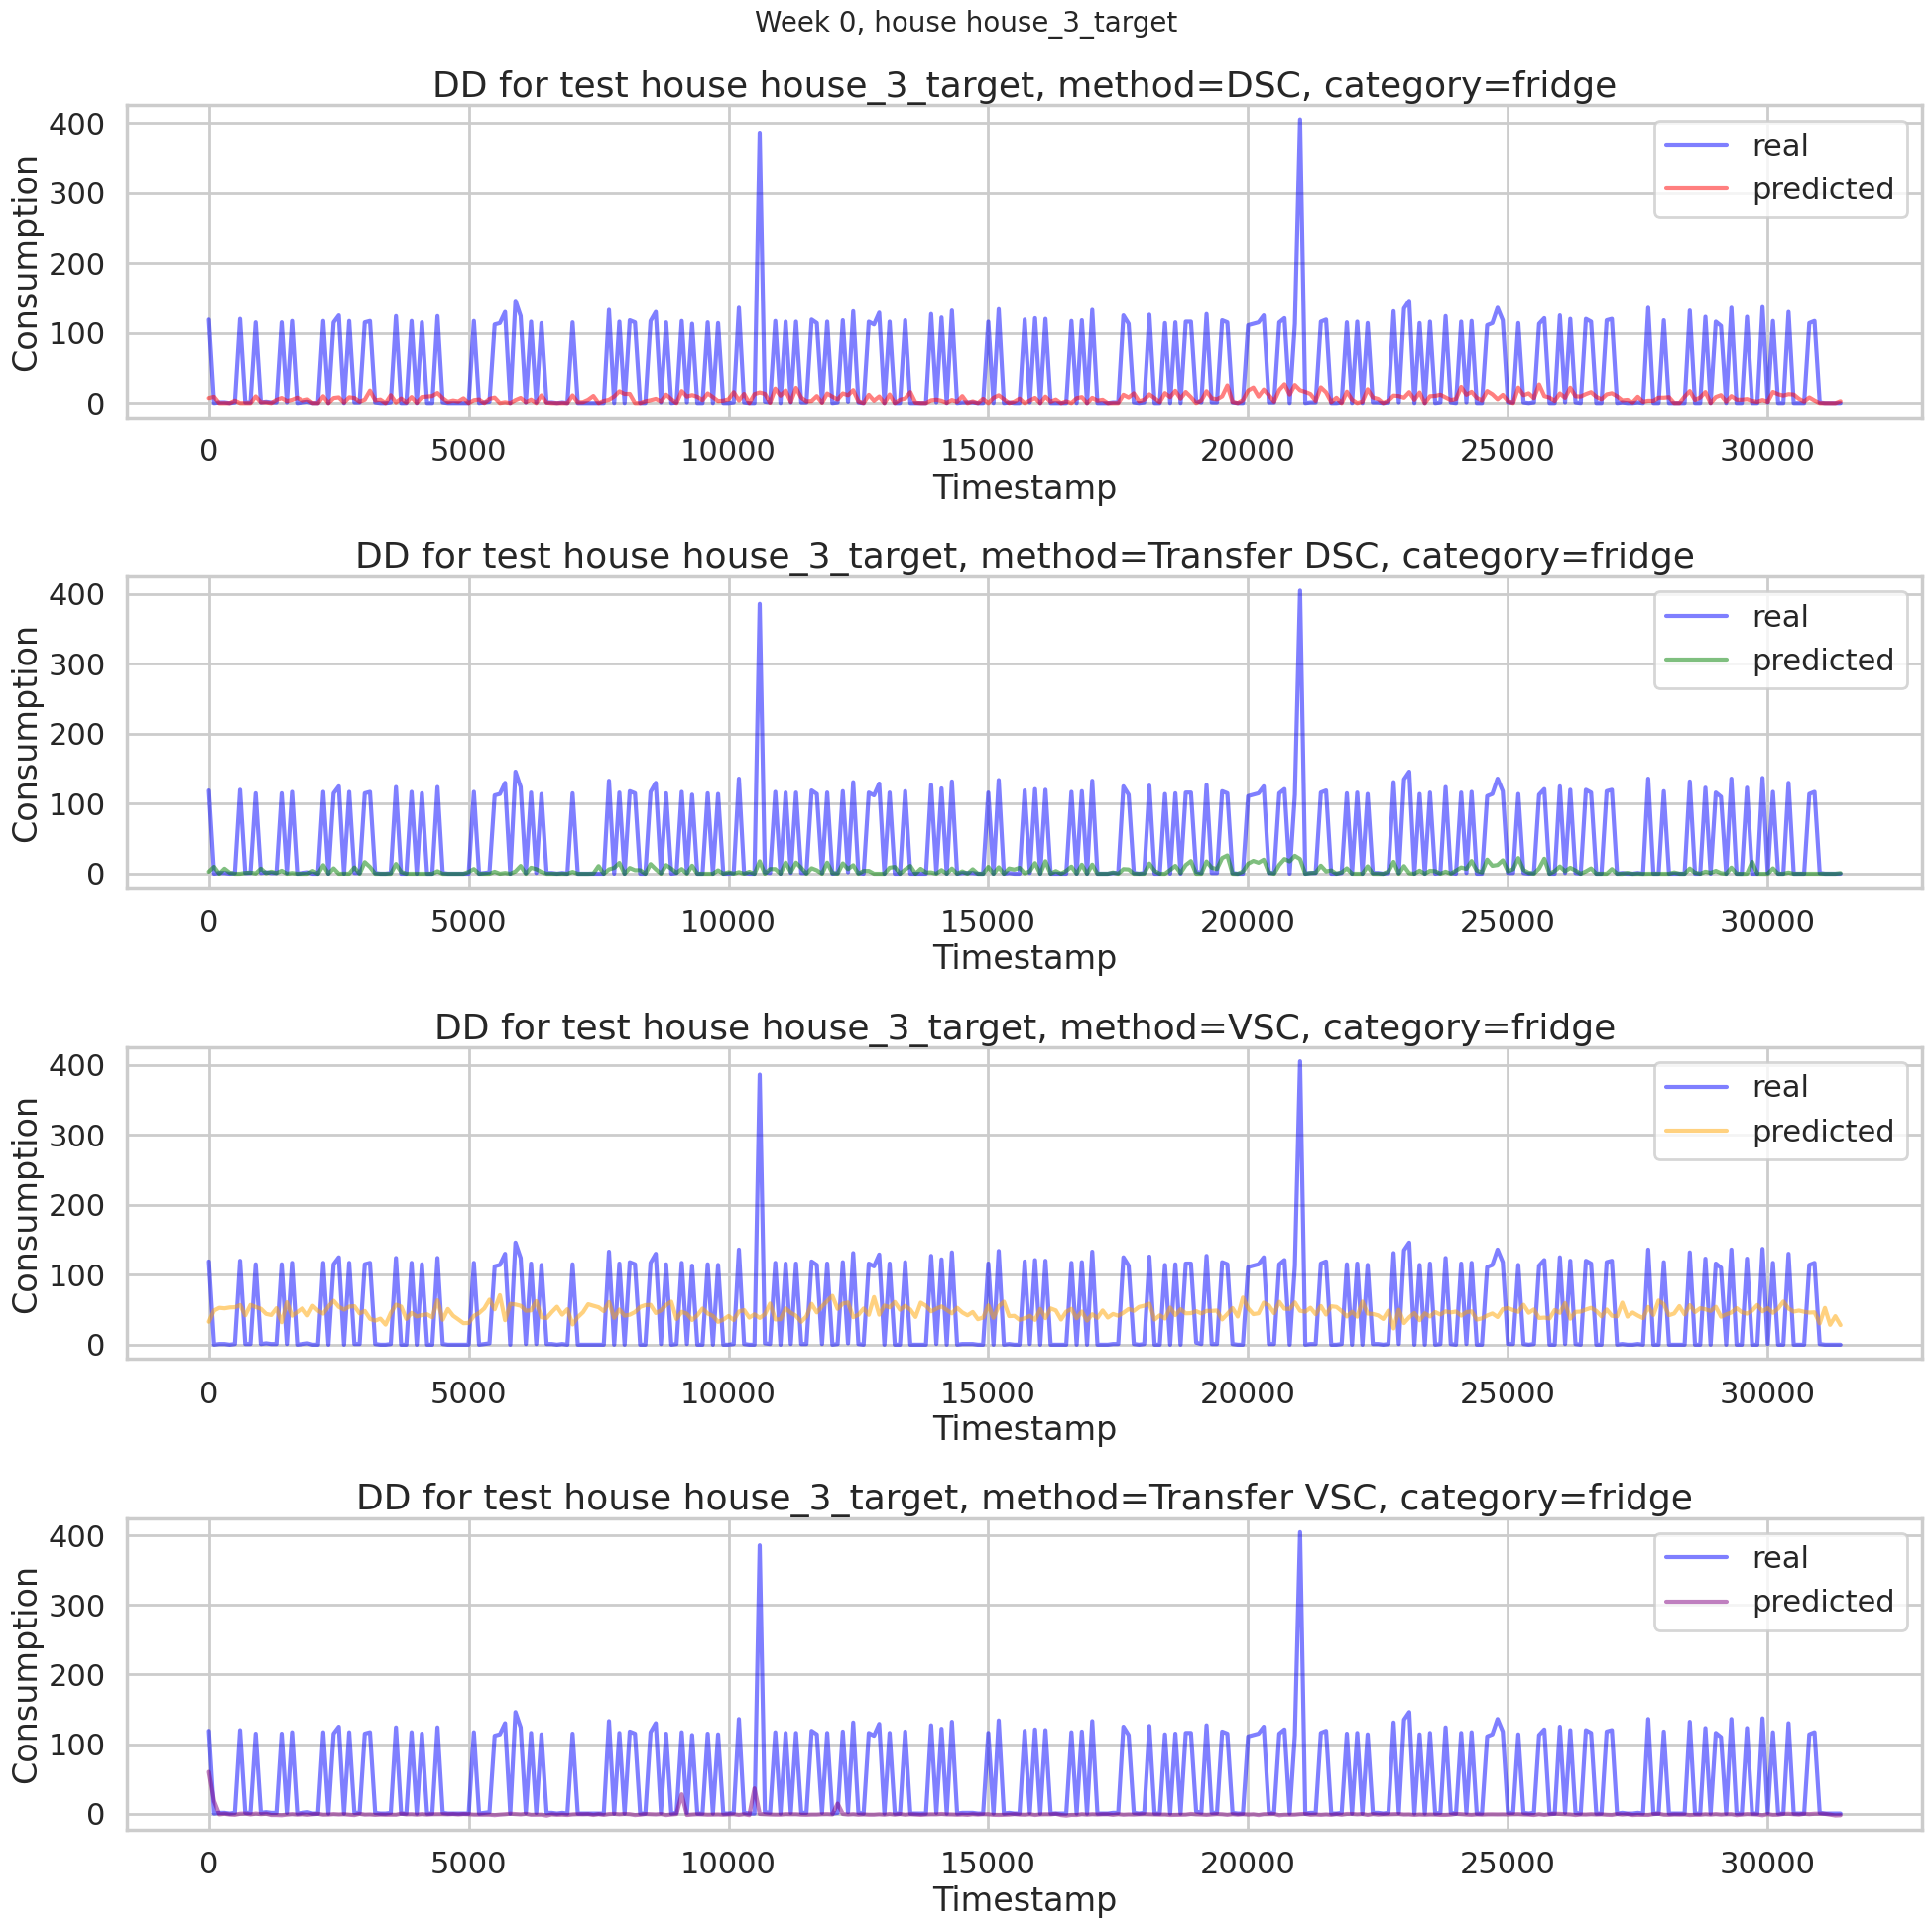

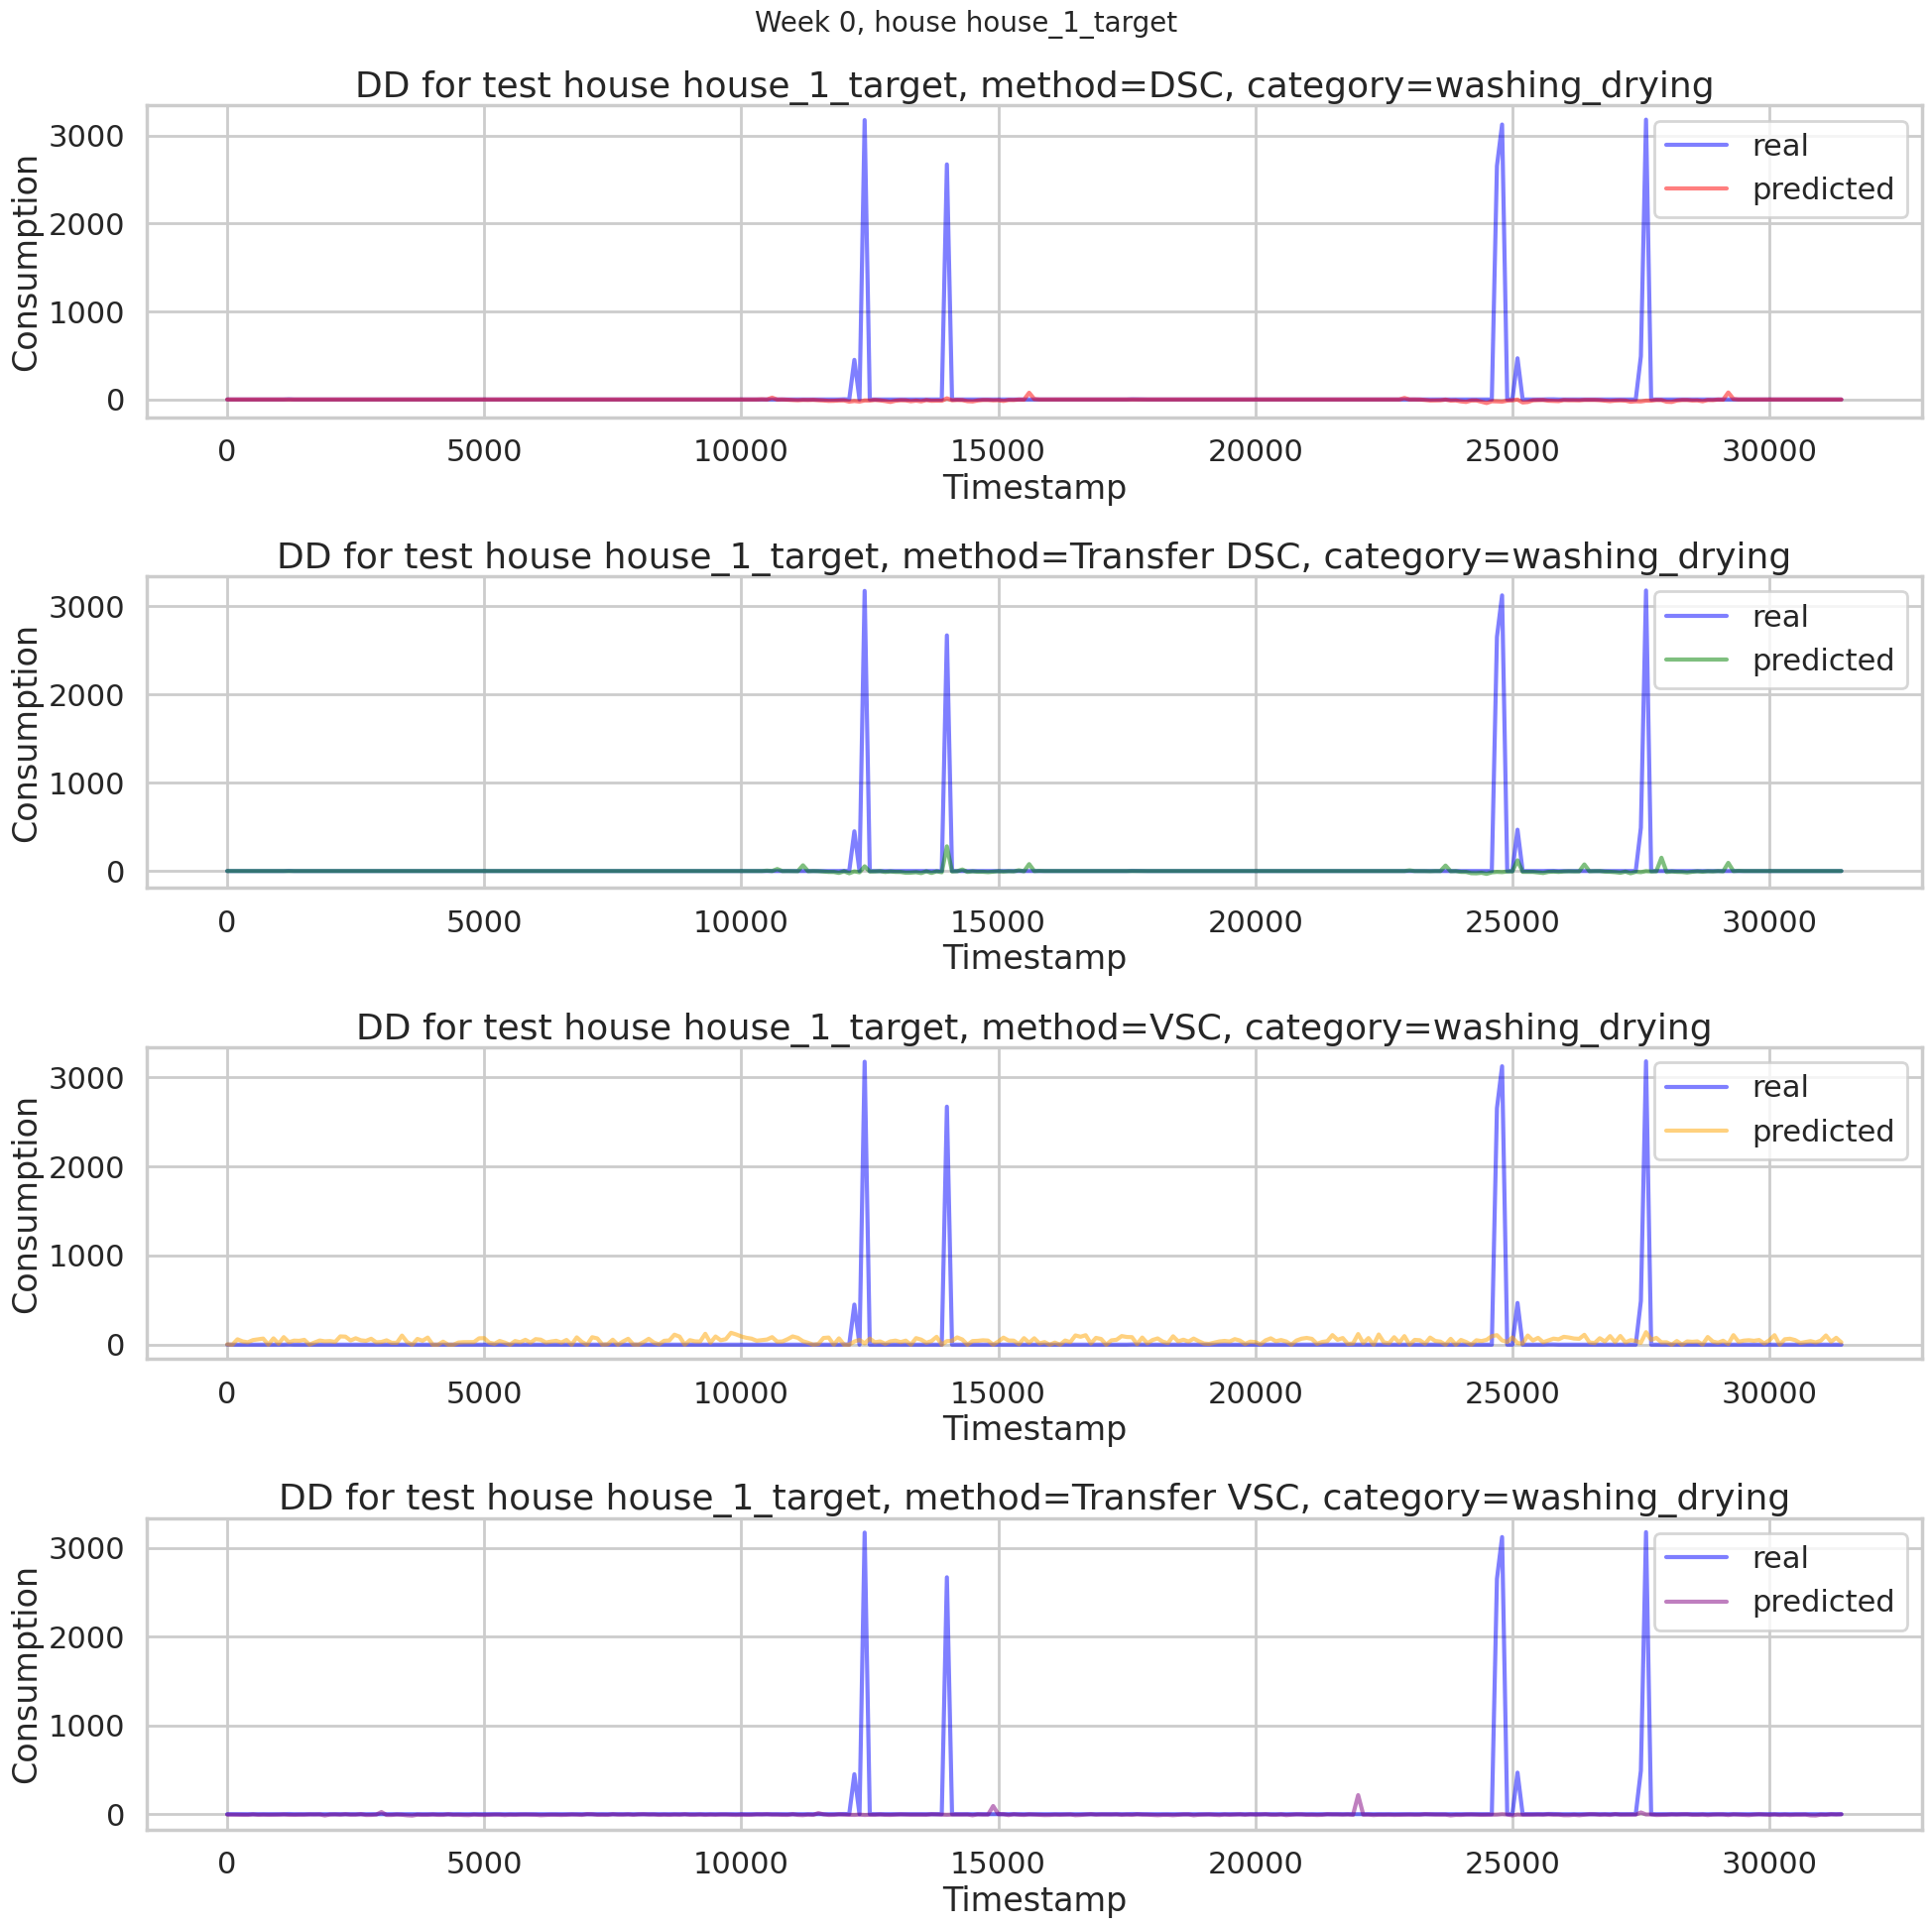

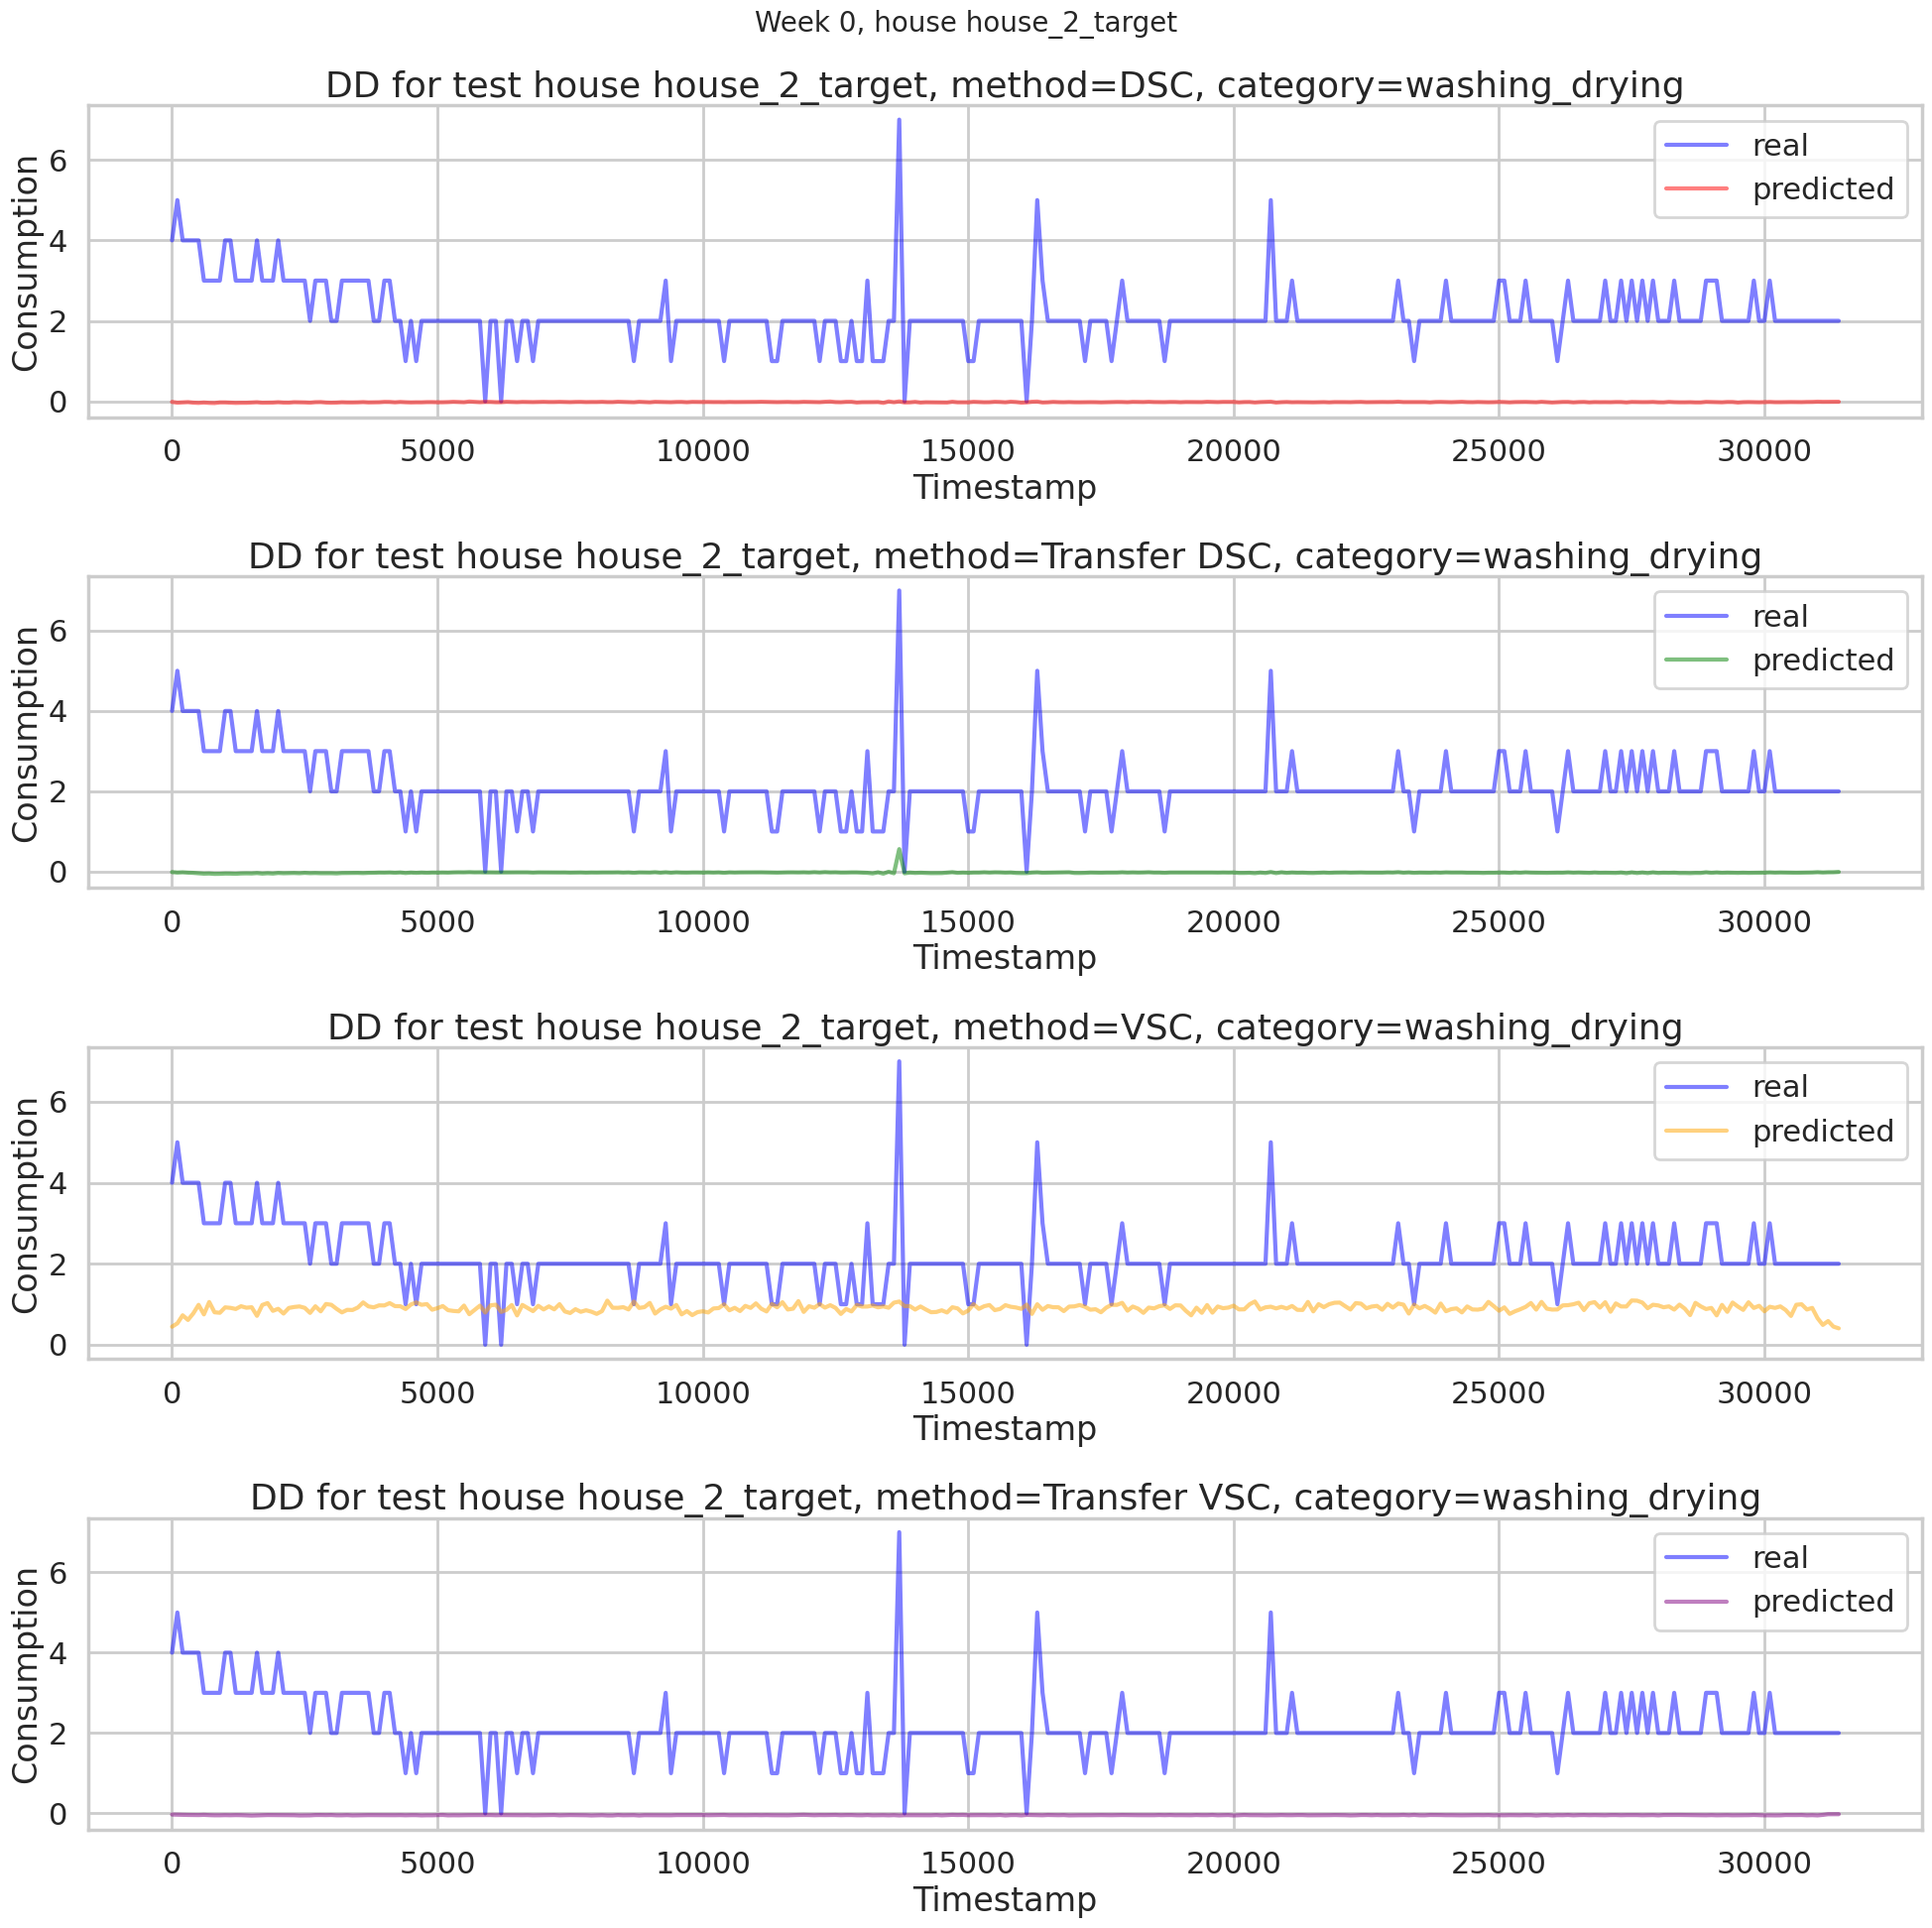

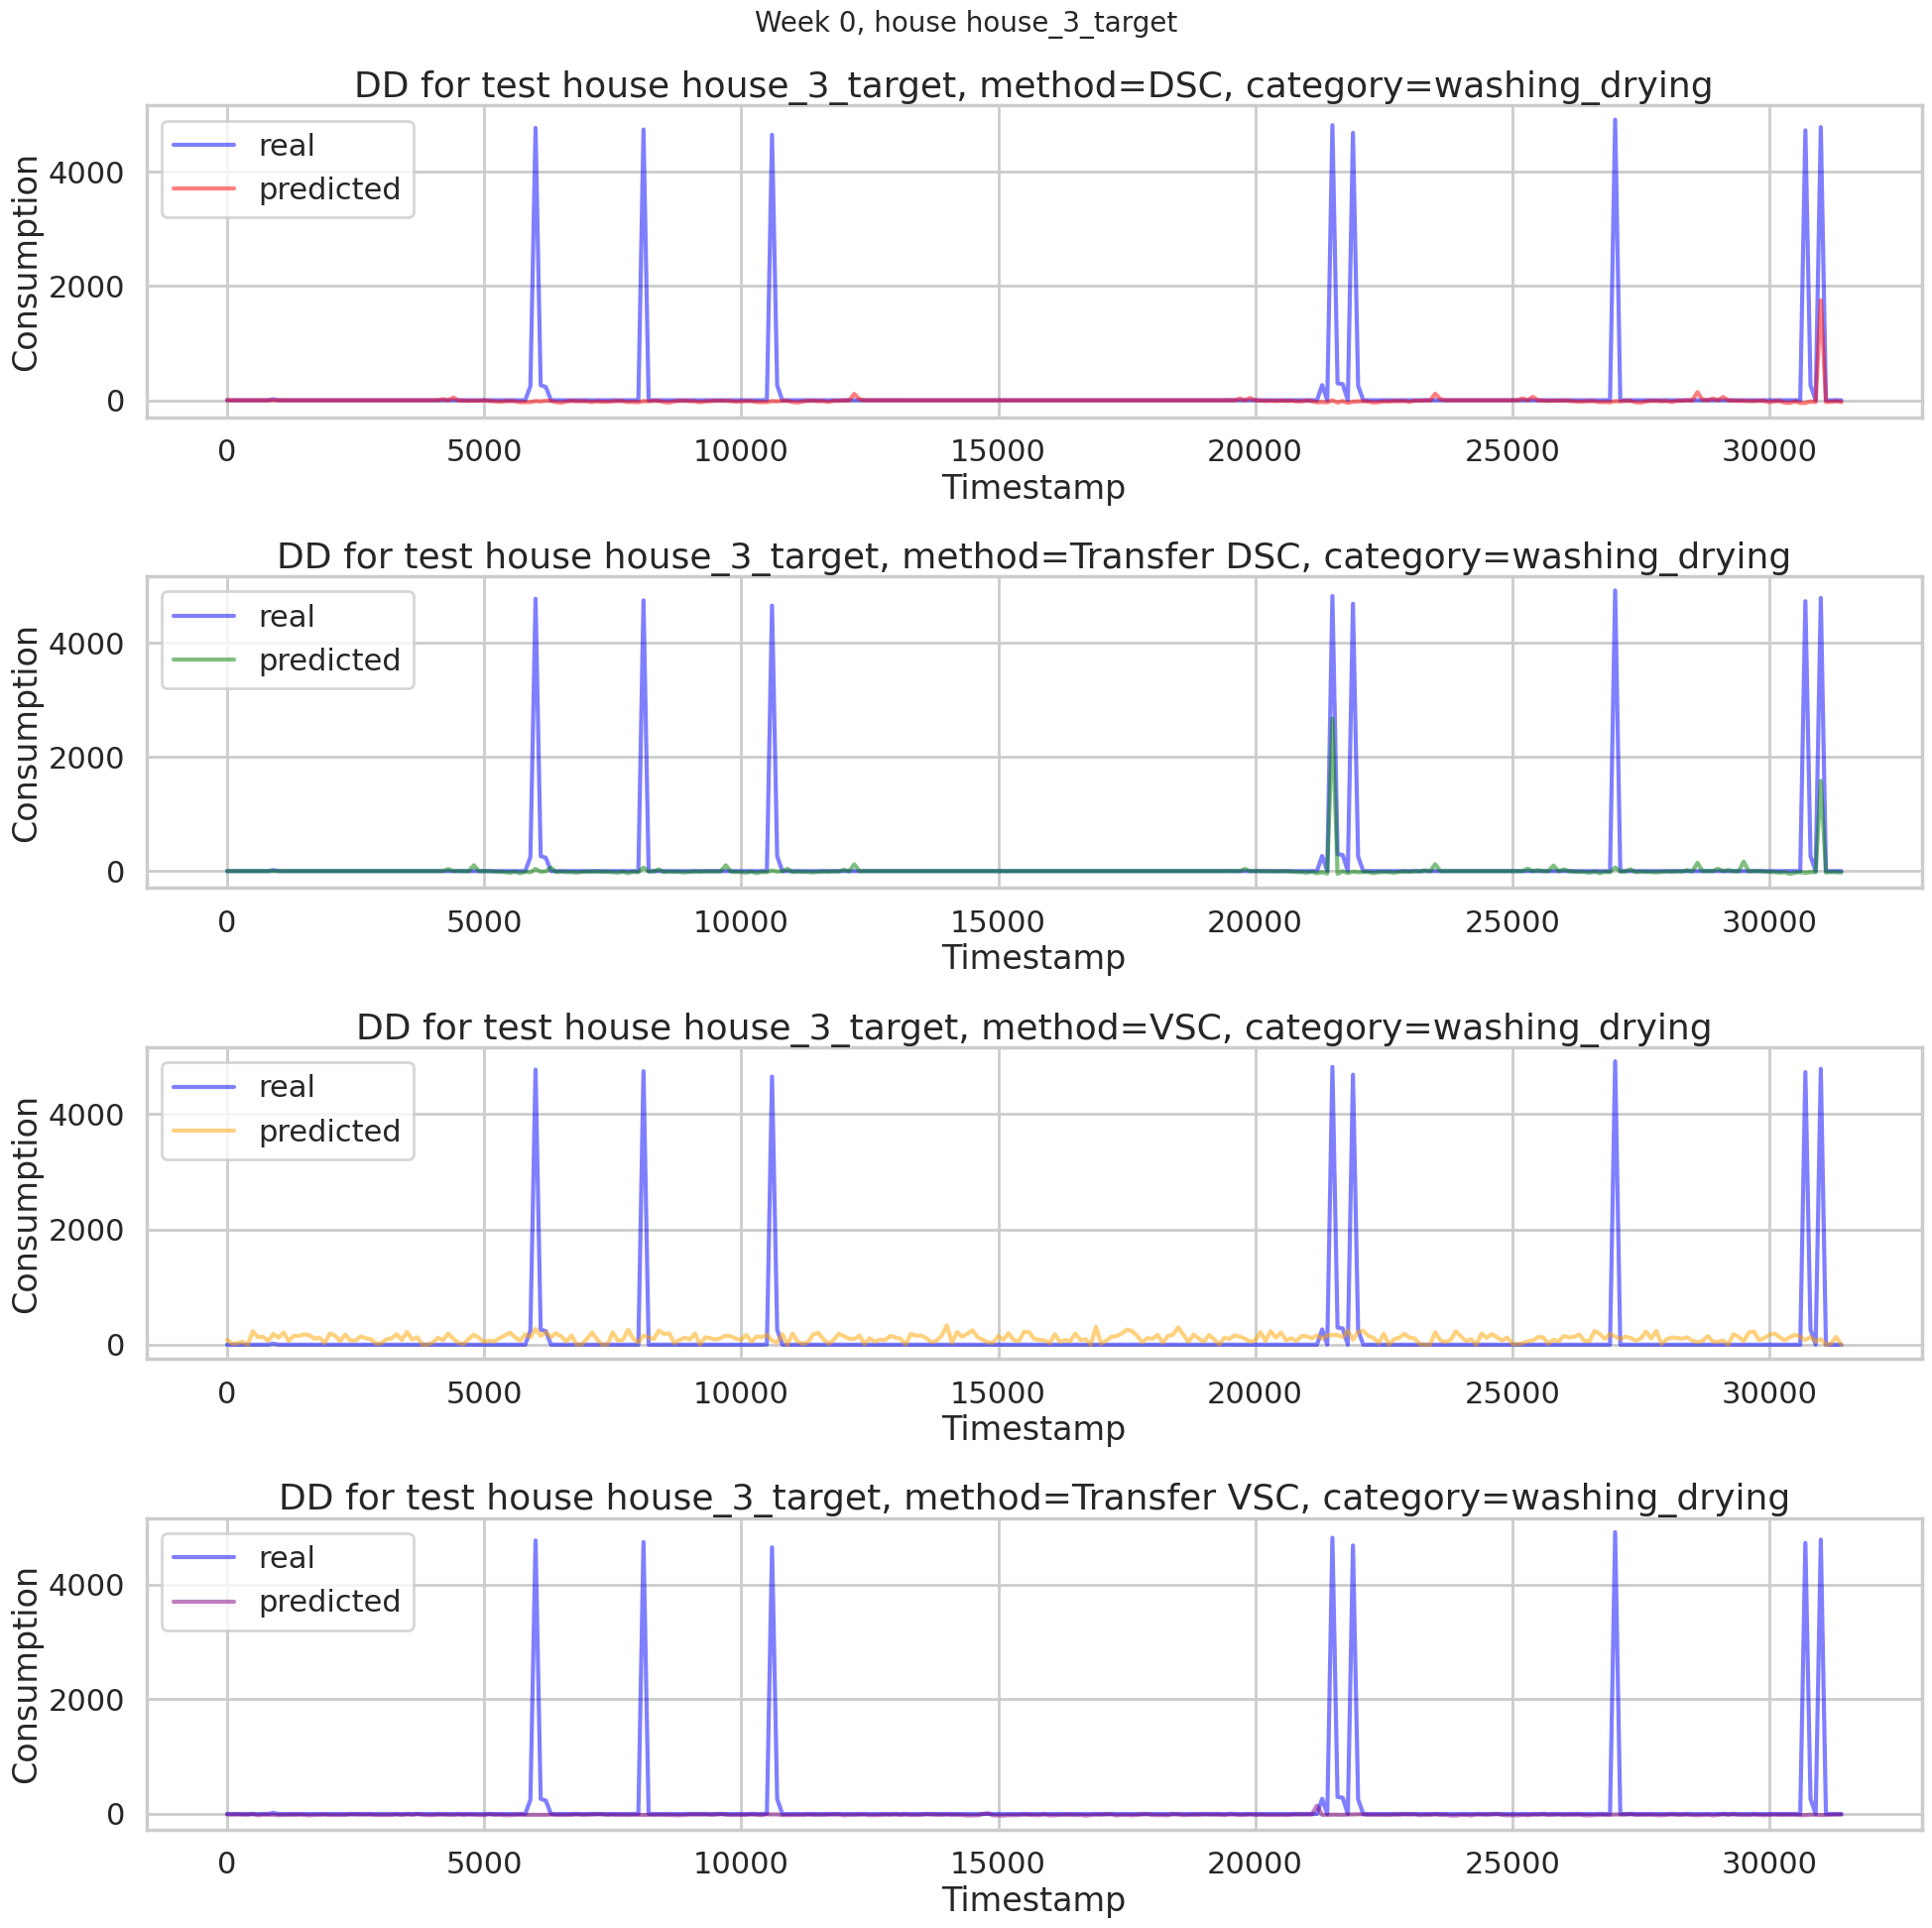

In [ ]:
get_all_category_plots_by_method(data, nb_houses, 1, data_type='test')

In [ ]:
week=1
c=1
house_train = 4

xt = train[week]['X'][appliance_categories[c]]
xt_pred = y_apps[week][appliance_categories[c]][:,0][:,house_train]

plt.figure(figsize=(12,6))
plt.plot([i*100 for i in range(len(xt_pred))], xt_pred, c='orange')
plt.plot([i*100 for i in range(len(xt))], xt.values[:,house_train], c='blue')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('norm2(X-AS)', fontsize=14)
plt.title('DD for train house {} for {} using DSC on mix'.format(house_train, appliance_categories[c]), fontsize=20)
plt.legend(['predicted',' real'])
#plt.axis((0,300,0,10000))
plt.savefig(fname='it.png')

In [ ]:
y_apps_test[week][appliance_categories[c]][:,0][:,house_test].shape

(168,)

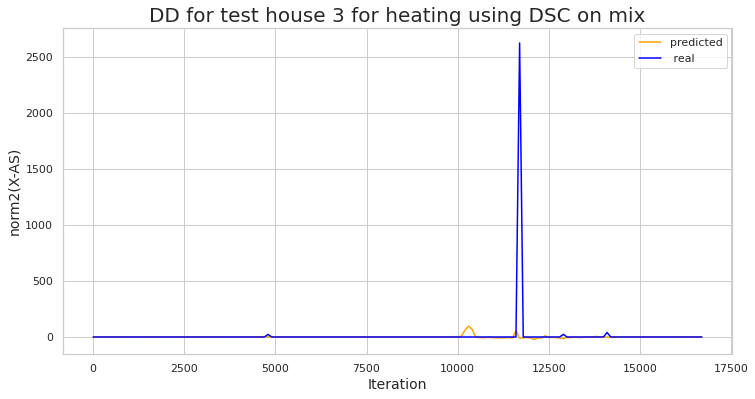

In [ ]:
week=2
c=3
house_test = 3

y_apps[week][appliance_categories[c]].shape
xt = test[week]['X'][appliance_categories[c]].values[:,house_test]
xt_pred = y_apps_test[week][appliance_categories[c]][:,0][:,house_test]

plt.figure(figsize=(12,6))
plt.plot([i*100 for i in range(len(xt_pred))], xt_pred, c='orange')
plt.plot([i*100 for i in range(len(xt))], xt, c='blue')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('norm2(X-AS)', fontsize=14)
plt.title('DD for test house {} for {} using DSC on mix'.format(house_test, appliance_categories[c]), fontsize=20)
plt.legend(['predicted',' real'])
#plt.axis((0,300,0,10000))
plt.savefig(fname='it.png')

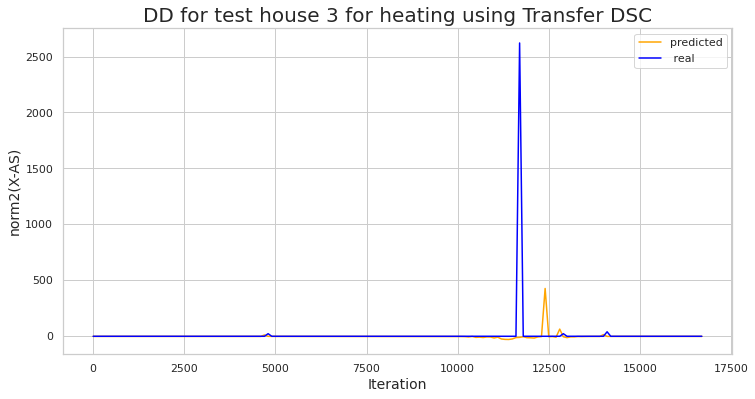

In [ ]:
xt = test[week]['X'][appliance_categories[c]]
xt_pred = y_apps_test_tdsc[week][appliance_categories[c]][:,0][:,house_test]

plt.figure(figsize=(12,6))
plt.plot([i*100 for i in range(len(xt_pred))], xt_pred, c='orange')
plt.plot([i*100 for i in range(len(xt))], xt.values[:,house_test], c='blue')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('norm2(X-AS)', fontsize=14)
plt.title('DD for test house {} for {} using Transfer DSC'.format(house_test, appliance_categories[c]), fontsize=20)
plt.legend(['predicted',' real'])
#plt.axis((0,300,0,10000))
plt.savefig(fname='it.png')

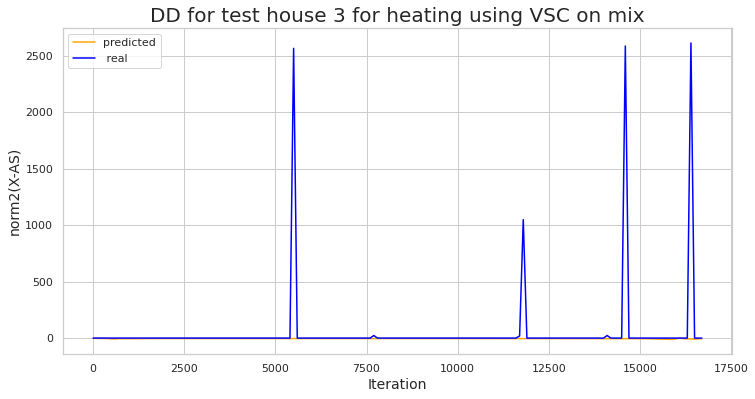

In [ ]:
 xt = test[week]['X'][appliance_categories[c]]
xt_pred = y_apps_test_vsc[week][appliance_categories[c]][:,0][:,house_test]

plt.figure(figsize=(12,6))
plt.plot([i*100 for i in range(len(xt_pred))], xt_pred, c='orange')
plt.plot([i*100 for i in range(len(xt))], xt.values[:,house_test], c='blue')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('norm2(X-AS)', fontsize=14)
plt.title('DD for test house {} for {} using VSC on mix'.format(house_test, appliance_categories[c]), fontsize=20)
plt.legend(['predicted',' real'])
#plt.axis((0,300,0,10000))
plt.savefig(fname='it.png')

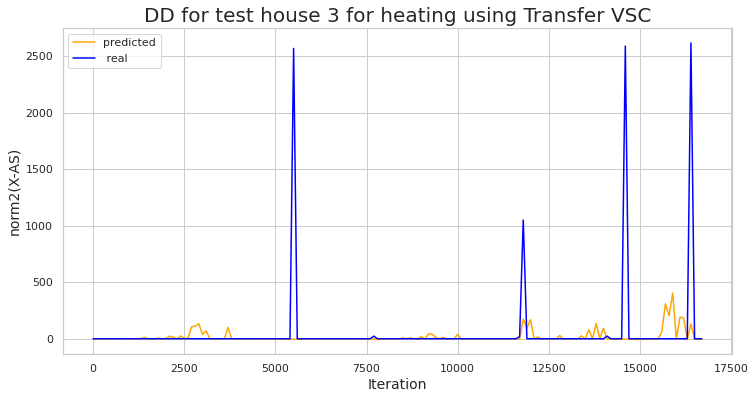

In [ ]:
xt = test[week]['X'][appliance_categories[c]]
xt_pred = y_apps_test_tvsc[week][appliance_categories[c]][:,0][:,house_test]

plt.figure(figsize=(12,6))
plt.plot([i*100 for i in range(len(xt_pred))], xt_pred, c='orange')
plt.plot([i*100 for i in range(len(xt))], xt.values[:,house_test], c='blue')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('norm2(X-AS)', fontsize=14)
plt.title('DD for test house {} for {} using Transfer VSC'.format(house_test, appliance_categories[c]), fontsize=20)
plt.legend(['predicted',' real'])
#plt.axis((0,300,0,10000))
plt.savefig(fname='it.png')

# **Hyperparameter tuning**

In [ ]:
input_size = 315
output_size = 315
encoding_dim = 64

nb_displays = 4
target_ind = 8

appliance_categories = list(train[0]['X'].keys())
weeks_to_train = len(train)

In [ ]:
# Define hyperparameters

#num_filters_list = [25, 50, 100]
#filter_size_list = [10, 20, 40]
#num_epochs_list = [151, 301, 401]
#learning_rate_list = [0.0005, 0.0001]


num_filters_list = [50, 100]
filter_size_list = [10, 20, 40]
num_epochs_list = [201]
learning_rate_list = [0.0005, 0.0001]

In [ ]:
def train_for_params(weeks, learning_rate, num_filters, filter_size, num_epochs, enable_transfer_learning, train_fct):
  y_apps = []
  y_apps_test = []

  display_every_n_epochs = num_epochs // nb_displays

  t = time.time()
  for week in range(weeks):
    print('WEEK {}'.format(week))
    current_y = dict()
    current_y_test = dict()
    for cat in appliance_categories:
      current_y_cat, current_y_test_cat = train_fct(week, cat, learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning)

      current_y[cat] = current_y_cat
      current_y_test[cat] = current_y_test_cat

    y_apps.append(current_y)
    y_apps_test.append(current_y_test)

  print('training took {} seconds'.format(round(time.time() - t, 2)))
  return y_apps, y_apps_test

In [ ]:
def get_accuracy(y_hat, data, weeks, target_only=False):
  res_list = []
  is_nan = []
  for week in range(weeks):
    if dd_acc_cat(y_hat[week], data[week], target_only)[1] < 1e10: #not nan
      res_list.append(dd_acc_cat(y_hat[week], data[week], target_only)[1])
    else:
      is_nan.append(week)

  return np.mean(res_list), is_nan

In [ ]:
#test_y_hat_dsc[0]['fridge'].shape, test[0]['X']['fridge'].values.shape, np.transpose(train_y_hat_dsc[0]['fridge'], (2, 1, 0)).shape, train[0]['X']['fridge'].values.shape

In [ ]:
weeks = 1
def tuning(learning_rate, num_filters, filter_size, num_epochs):
    print('########## Training on num_filters = {}, filter_size = {}, num_epochs = {} learning_rate = {} \n'.format(num_filters, filter_size, num_epochs, learning_rate))
    print('DSC')
    train_y_hat_dsc, test_y_hat_dsc = train_for_params(weeks, learning_rate, num_filters, filter_size, num_epochs, enable_transfer_learning=False, train_fct=train_on_week_and_category)
    print('TRANSFER DSC')
    train_y_hat_tdsc, test_y_hat_tdsc = train_for_params(weeks, learning_rate, num_filters, filter_size, num_epochs, enable_transfer_learning=True, train_fct=train_on_week_and_category)
    print('VSC')
    train_y_hat_vsc, test_y_hat_vsc = train_for_params(weeks, learning_rate, num_filters, filter_size, num_epochs, enable_transfer_learning=False, train_fct=VSC_train_on_week_and_category)
    print('TRANSFER VSC')
    train_y_hat_tvsc, test_y_hat_tvsc = train_for_params(weeks, learning_rate, num_filters, filter_size, num_epochs, enable_transfer_learning=True, train_fct=VSC_train_on_week_and_category)
    print('\n')

    return (
        {'learning_rate': learning_rate,
         'num_filters': num_filters,
          'filter_size': filter_size,
          'num_epochs': num_epochs,
          'DD_accuracy_DSC_and_nans': get_accuracy(train_y_hat_dsc, train, weeks),
          'DD_accuracy_TransferDSC_and_nans': get_accuracy(train_y_hat_tdsc, train, weeks, target_only=True),
          'DD_accuracy_VSC_and_nans': get_accuracy(train_y_hat_vsc, train, weeks),
          'DD_accuracy_TransferVSC_and_nans': get_accuracy(train_y_hat_tvsc, train, weeks, target_only=True),
          }
        )

In [ ]:
res_dict = list()
#weeks = 5

t_before = time.time()
total_nb_of_trials = len(num_filters_list) * len(filter_size_list) * len(num_epochs_list) * len(learning_rate_list)
trial = 0

for num_filters in num_filters_list:
  for filter_size in filter_size_list:
    for num_epochs in num_epochs_list:
      for learning_rate in learning_rate_list:
        trial = trial + 1
        print('LOOP {}/{}'.format(trial, total_nb_of_trials))

        res_dict.append(tuning(learning_rate, num_filters, filter_size, num_epochs))
        with open('/content/drive/MyDrive/tuning_deep_learning.pickle', 'wb') as f:
          pickle.dump({'nb_trials': trial, 'res_dict': res_dict}, f)

print('Total tuning took {}s'.format(round(time.time() - t_before, 2)))

In [ ]:
with open('/content/drive/MyDrive/tuning_deep_learning.pickle', 'rb') as f:
  c=pickle.load(f)

In [ ]:
[[elt[acc][0] for elt in res_dict] for acc in ['DD_accuracy_DSC_and_nans', 'DD_accuracy_TransferDSC_and_nans', 'DD_accuracy_VSC_and_nans', 'DD_accuracy_TransferVSC_and_nans'] if acc != 'nan']

[[0.883,
  0.866,
  0.867,
  0.869,
  0.658,
  0.878,
  0.82,
  0.845,
  0.821,
  0.876,
  -0.386,
  0.823],
 [0.908,
  0.918,
  0.843,
  0.898,
  0.899,
  0.898,
  0.812,
  0.929,
  0.872,
  0.926,
  0.813,
  0.83],
 [0.873,
  0.86,
  0.848,
  0.87,
  0.873,
  0.848,
  0.866,
  0.879,
  0.841,
  0.872,
  0.715,
  0.864],
 [nan, 0.832, nan, 0.874, nan, 0.9, nan, 0.791, nan, 0.836, nan, 0.677]]

In [ ]:
best = [max([elt[acc][0] for elt in res_dict if elt[acc][0] < 1]) for acc in ['DD_accuracy_DSC_and_nans', 'DD_accuracy_TransferDSC_and_nans', 'DD_accuracy_VSC_and_nans', 'DD_accuracy_TransferVSC_and_nans'] if acc != 'nan']

In [ ]:
best

[0.883, 0.929, 0.879, 0.9]

In [ ]:
for acc_ind, acc in enumerate(['DD_accuracy_DSC_and_nans', 'DD_accuracy_TransferDSC_and_nans', 'DD_accuracy_VSC_and_nans', 'DD_accuracy_TransferVSC_and_nans']):
  best_params = [x for x in res_dict if x[acc][0] == best[acc_ind]]
  print('The best parameters for {} are {}'.format(acc, best_params))

The best parameters for DD_accuracy_DSC_and_nans are [{'learning_rate': 0.0005, 'num_filters': 50, 'filter_size': 10, 'num_epochs': 201, 'DD_accuracy_DSC_and_nans': (0.883, []), 'DD_accuracy_TransferDSC_and_nans': (0.908, []), 'DD_accuracy_VSC_and_nans': (0.873, []), 'DD_accuracy_TransferVSC_and_nans': (nan, [0])}]
The best parameters for DD_accuracy_TransferDSC_and_nans are [{'learning_rate': 0.0001, 'num_filters': 100, 'filter_size': 10, 'num_epochs': 201, 'DD_accuracy_DSC_and_nans': (0.845, []), 'DD_accuracy_TransferDSC_and_nans': (0.929, []), 'DD_accuracy_VSC_and_nans': (0.879, []), 'DD_accuracy_TransferVSC_and_nans': (0.791, [])}]
The best parameters for DD_accuracy_VSC_and_nans are [{'learning_rate': 0.0001, 'num_filters': 100, 'filter_size': 10, 'num_epochs': 201, 'DD_accuracy_DSC_and_nans': (0.845, []), 'DD_accuracy_TransferDSC_and_nans': (0.929, []), 'DD_accuracy_VSC_and_nans': (0.879, []), 'DD_accuracy_TransferVSC_and_nans': (0.791, [])}]
The best parameters for DD_accuracy_T

In [ ]:
best_params = [x for x in res_dict if x]

In [ ]:
res_dict

[{'learning_rate': 0.0005,
  'num_filters': 50,
  'filter_size': 10,
  'num_epochs': 201,
  'DD_accuracy_DSC_and_nans': (0.883, []),
  'DD_accuracy_TransferDSC_and_nans': (0.908, []),
  'DD_accuracy_VSC_and_nans': (0.873, []),
  'DD_accuracy_TransferVSC_and_nans': (nan, [0])},
 {'learning_rate': 0.0001,
  'num_filters': 50,
  'filter_size': 10,
  'num_epochs': 201,
  'DD_accuracy_DSC_and_nans': (0.866, []),
  'DD_accuracy_TransferDSC_and_nans': (0.918, []),
  'DD_accuracy_VSC_and_nans': (0.86, []),
  'DD_accuracy_TransferVSC_and_nans': (0.832, [])},
 {'learning_rate': 0.0005,
  'num_filters': 50,
  'filter_size': 20,
  'num_epochs': 201,
  'DD_accuracy_DSC_and_nans': (0.867, []),
  'DD_accuracy_TransferDSC_and_nans': (0.843, []),
  'DD_accuracy_VSC_and_nans': (0.848, []),
  'DD_accuracy_TransferVSC_and_nans': (nan, [0])},
 {'learning_rate': 0.0001,
  'num_filters': 50,
  'filter_size': 20,
  'num_epochs': 201,
  'DD_accuracy_DSC_and_nans': (0.869, []),
  'DD_accuracy_TransferDSC_and_na

In [ ]:
import multiprocessing
from itertools import product

res_dict = list()

def tuning_by_typle(input):
  return tuning(*input)

if __name__ == '__main__':
    multiprocessing.set_start_method('spawn')
    pool = multiprocessing.Pool(processes=4) # specify number of processes to run in parallel
    inputs = [1, 2, 3, 4, 5] # list of inputs to the function
    res_dict = pool.map(tuning_by_typle, list(product(num_filters_list, filter_size_list, num_epochs_list))) # run the function on the inputs in parallel
    pool.close()
    pool.join()
